## Advanced Lane Finding Project


Steps for the pipeline are;

1. Camera calibration
1. Distortion correction
1. Color/gradient threshold
1. Perspective transform
1. Detect lane lines
1. Determine the lane curvatur

In [67]:
# Code cell 1
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

%matplotlib inline



## Calibrate The Camera

In [77]:
# Code Cell 2
class CalibrateCamera:
    # Note these are class variables, so you only every have to read images once
    ret, mtx, dist, rvecs, tvecs = None,None,None,None,None
    objpoints = []
    imgpoints = []
    cal_images = []
    
    def __init__(self):
        self.readCalibrationImages()

    def readCalibrationImages(self):
        if len (self.cal_images) > 0:
            return
        # prepare object points
        nx = 9 #TODO: enter the number of inside corners in x
        ny = 6 #TODO: enter the number of inside corners in y

        objp = np.zeros((nx*ny,3), np.float32)
        objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x,y coord

        images = glob.glob("./camera_cal/*.jpg")

        # Make a list of calibration images

        for fname in images:
            print (fname)
            img = mpimg.imread(fname)

            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

            # If found, draw corners
            if ret == True:
                self.imgpoints.append(corners)
                self.objpoints.append(objp)
                # Draw and display the corners
                cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                #print (corners[0], corners[nx-1],corners[-1],corners[-nx])

            self.cal_images.append((img,fname))

    def getCalibrationImages(self):
        return self.cal_images
    
    def getCameraCalibration(self,image_shape):
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, image_shape, None, None)
        return self.ret, self.mtx, self.dist, self.rvecs, self.tvecs

    def undistortImage(self,image):
        if self.ret == None:
            self.getCameraCalibration(image.shape[::-1][1:3])
        return cv2.undistort(image,self.mtx,self.dist,None,self.mtx)

./camera_cal/calibration5.jpg
./camera_cal/calibration4.jpg
./camera_cal/calibration6.jpg
./camera_cal/calibration7.jpg
./camera_cal/calibration3.jpg
./camera_cal/calibration2.jpg
./camera_cal/calibration1.jpg
./camera_cal/calibration20.jpg
./camera_cal/calibration19.jpg
./camera_cal/calibration18.jpg
./camera_cal/calibration15.jpg
./camera_cal/calibration14.jpg
./camera_cal/calibration16.jpg
./camera_cal/calibration17.jpg
./camera_cal/calibration13.jpg
./camera_cal/calibration12.jpg
./camera_cal/calibration10.jpg
./camera_cal/calibration11.jpg
./camera_cal/calibration9.jpg
./camera_cal/calibration8.jpg


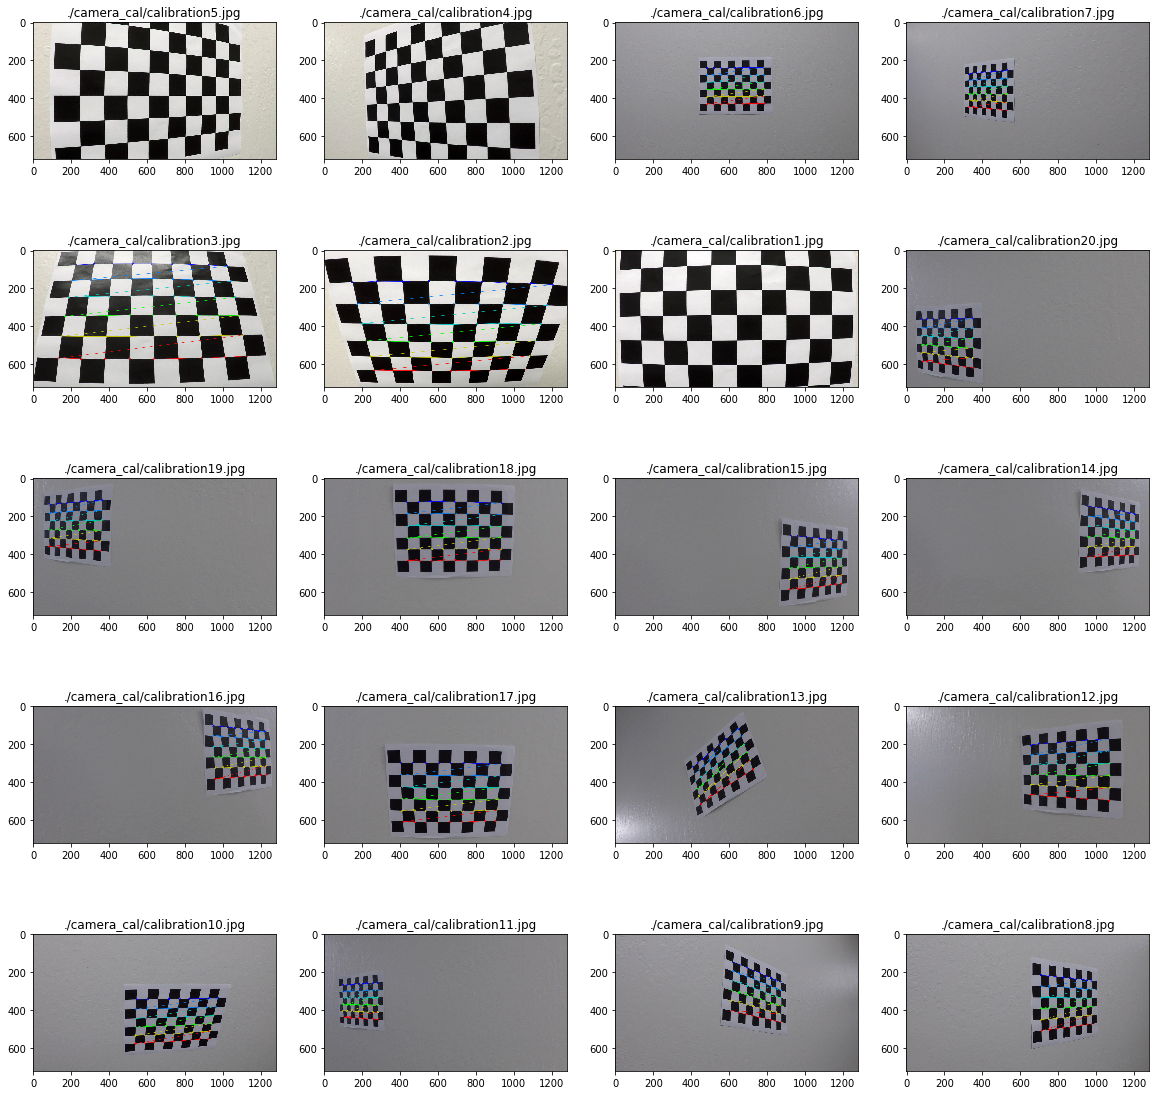

In [78]:
#Code Cell 3
camCal = CalibrateCamera()

cal_images = camCal.getCalibrationImages()


f, ax = plt.subplots(5, 4, figsize=(20, 20))

ax = ax.ravel()

for cal_image,axi in zip(cal_images,ax):
    axi.imshow(cal_image[0])
    axi.set_title(cal_image[1])

plt.subplots_adjust(hspace=0.3)
plt.show()



## Threshold Functions

## Show Chessboard Undistorted

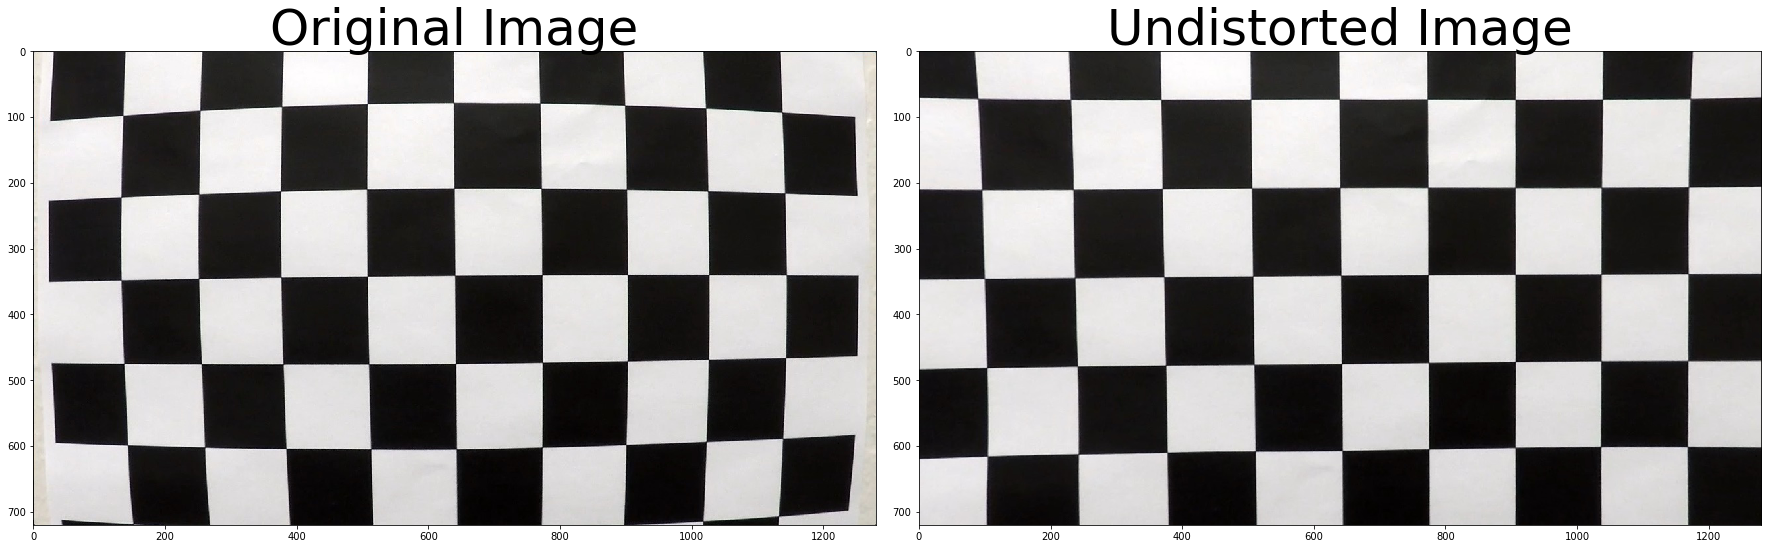

In [79]:
#Code Cell 4
cal_image = mpimg.imread("./camera_cal/calibration1.jpg")

undistorted = camCal.undistortImage(cal_image,)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cal_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Undistort Test Image

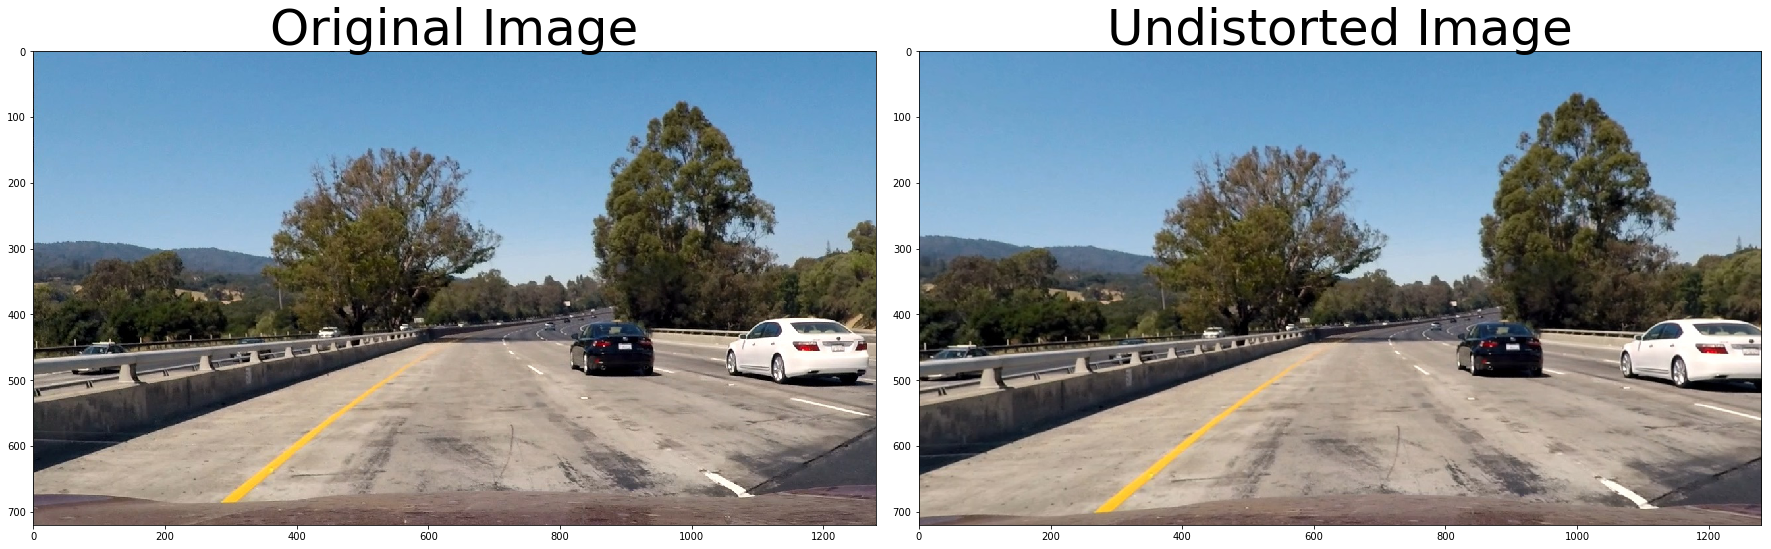

In [8]:
#Code Cell 5
cal_image = mpimg.imread("./test_images/test1.jpg")

camCal.getCameraCalibration(cal_image.shape[::-1][1:3])

undistorted = camCal.undistortImage(cal_image,)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cal_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Gradient & Threshold functions


In [9]:
#Code Cell 6
# Class that takes an image and lets you pick appropriate Channels from different
# Color spaces
class ImageChannel():
    image = None
    def __init__(self,img):
        # Initial RGB image
        self.image = img

    def getChannel(self, channel):
        """Dispatch method"""
        # Get the method from 'self'. Default to a lambda.
        method = getattr(self, channel, lambda: "nothing")
        # Call the method as we return it
        return method()

    def GRAY(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2GRAY)

    def RGB_R(self):
        return image[:,:,0]

    def RGB_G(self):
        return image[:,:,1]

    def RGB_B(self):
        return image[:,:,2]

    def HLS_H(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,0]

    def HLS_L(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,1]

    def HLS_S(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,2]
    
    def HSV_H(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,0]

    def HSV_S(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,1]

    def HSV_V(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,2]

    
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', channel="GRAY", sobel_kernel=3, thresh=(0,255)):
    # Convert to appropriate channel
    ic = ImageChannel(img)
    img_channel = ic.getChannel(channel)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, channel="GRAY", sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to appropriate channel
    ic = ImageChannel(img)
    img_channel = ic.getChannel(channel)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, channel="GRAY", sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to appropriate channel
    ic = ImageChannel(img)
    img_channel = ic.getChannel(channel)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def color_thresh (img, channel="GRAY", thresh=(170,255)):
    ic = ImageChannel(img)
    img_channel = ic.getChannel(channel)

    binary = np.zeros_like(img_channel)
    binary[(img_channel >= thresh[0]) & (img_channel <= thresh[1])] = 1
    return binary



## Gradient & Threshold Visualizations

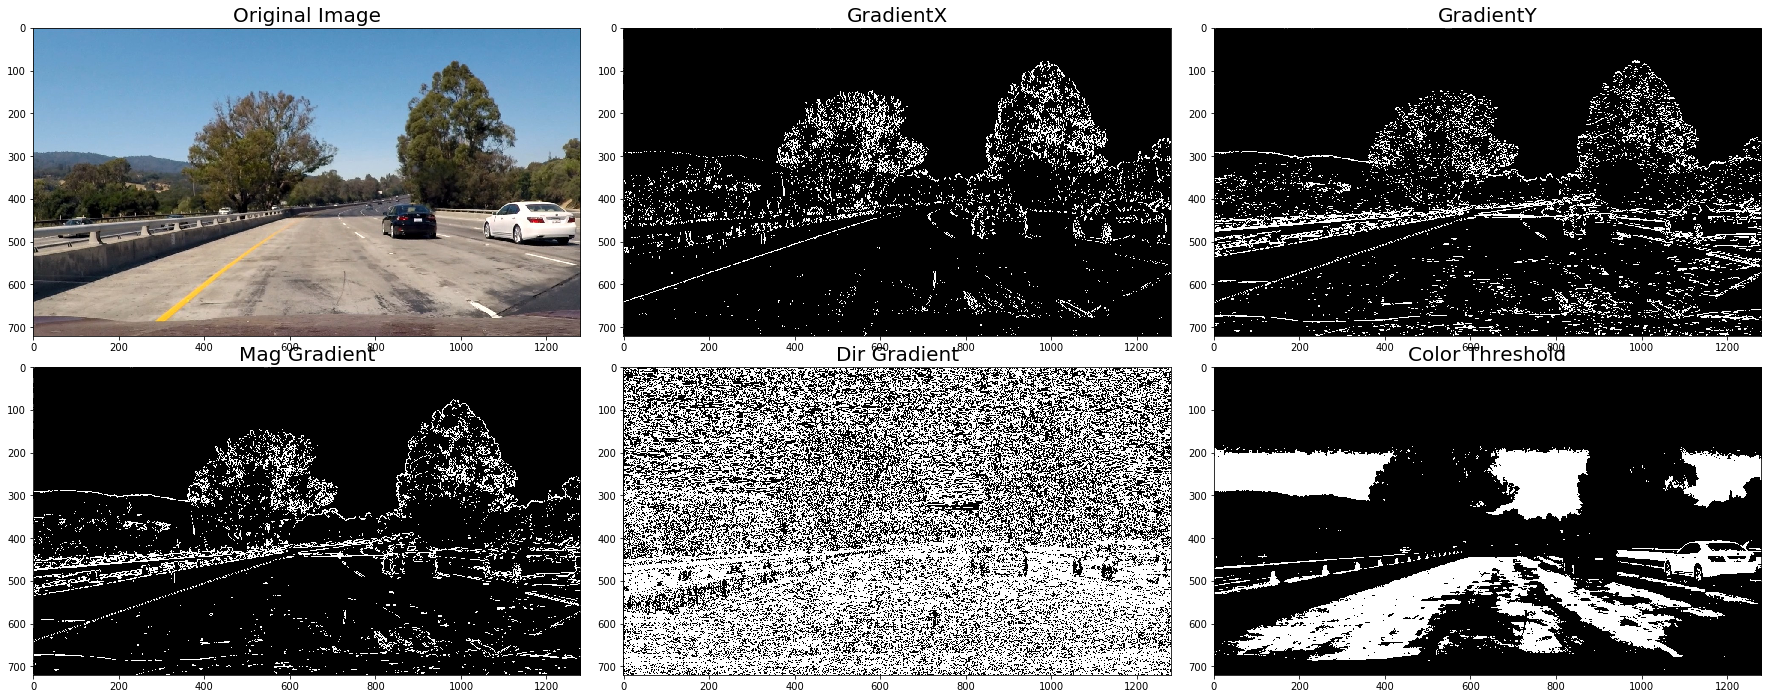

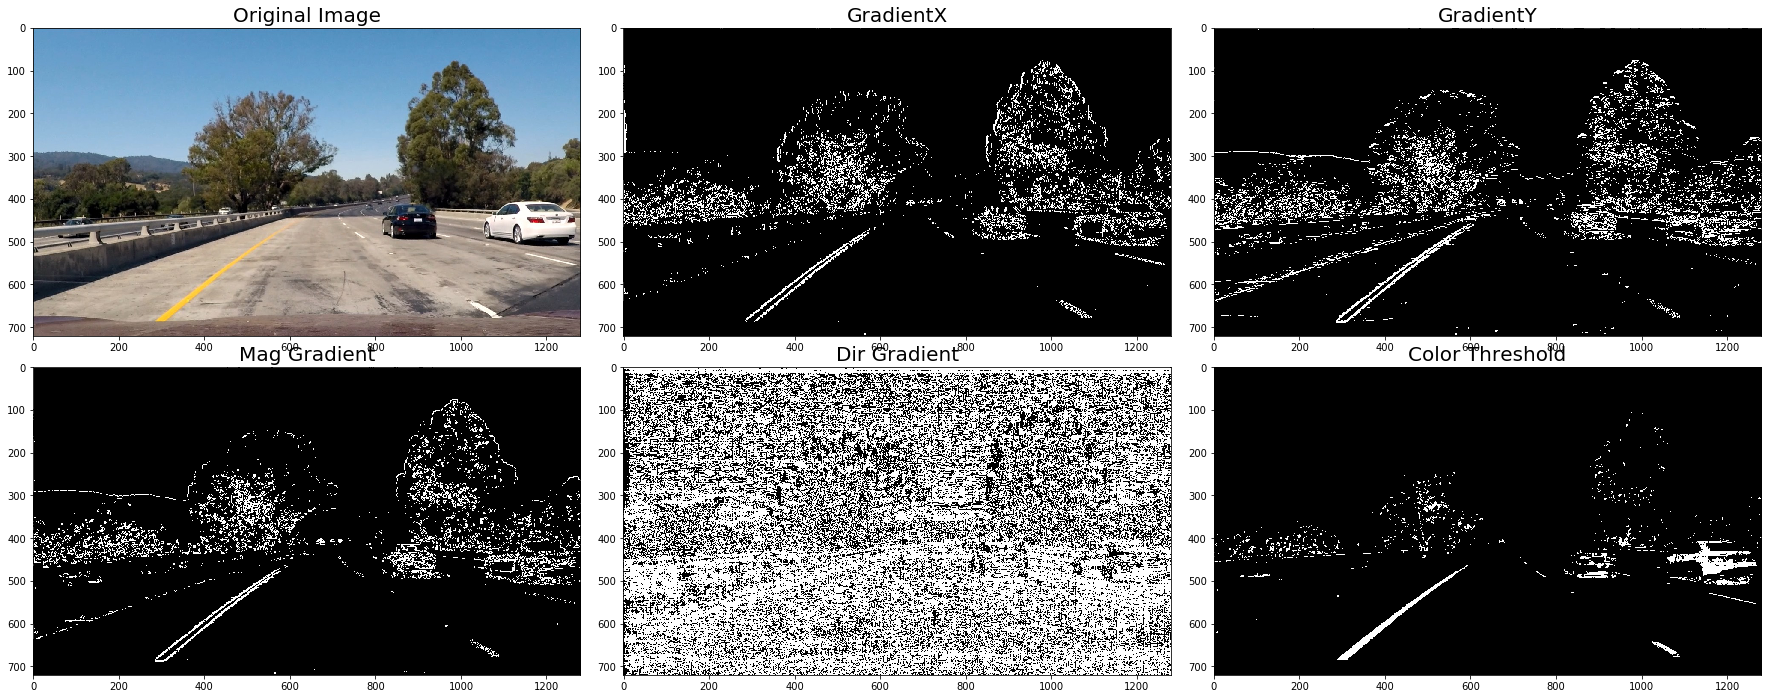

In [10]:
#Code Cell 7
# Read in an image and grayscale it
ksize = 3
image = mpimg.imread('./test_images/test1.jpg')

gradx = abs_sobel_thresh(image, orient='x', channel="GRAY", sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', channel="GRAY", sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, channel="GRAY", sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, channel="GRAY", sobel_kernel=ksize, thresh=(0.7, np.pi/2))
color_binary = color_thresh(image, channel="GRAY", thresh=(170,255))


f, ax = plt.subplots(2, 3, figsize=(24, 10))
f.tight_layout()
ax = ax.ravel()

ax[0].imshow(image)
ax[0].set_title('Original Image', fontsize=20)
ax[1].imshow(gradx, cmap='gray')
ax[1].set_title('GradientX', fontsize=20)
ax[2].imshow(grady, cmap='gray')
ax[2].set_title('GradientY', fontsize=20)
ax[3].imshow(mag_binary, cmap='gray')
ax[3].set_title('Mag Gradient', fontsize=20)
ax[4].imshow(dir_binary, cmap='gray')
ax[4].set_title('Dir Gradient', fontsize=20)
ax[5].imshow(color_binary, cmap='gray')
ax[5].set_title('Color Threshold', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

gradx = abs_sobel_thresh(image, orient='x', channel="HLS_S", sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', channel="HLS_S", sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, channel="HLS_S", sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, channel="HLS_S", sobel_kernel=ksize, thresh=(0.7, np.pi/2))
color_binary = color_thresh(image, channel="HLS_S", thresh=(150,255))


f, ax = plt.subplots(2, 3, figsize=(24, 10))
f.tight_layout()
ax = ax.ravel()

ax[0].imshow(image)
ax[0].set_title('Original Image', fontsize=20)
ax[1].imshow(gradx, cmap='gray')
ax[1].set_title('GradientX', fontsize=20)
ax[2].imshow(grady, cmap='gray')
ax[2].set_title('GradientY', fontsize=20)
ax[3].imshow(mag_binary, cmap='gray')
ax[3].set_title('Mag Gradient', fontsize=20)
ax[4].imshow(dir_binary, cmap='gray')
ax[4].set_title('Dir Gradient', fontsize=20)
ax[5].imshow(color_binary, cmap='gray')
ax[5].set_title('Color Threshold', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

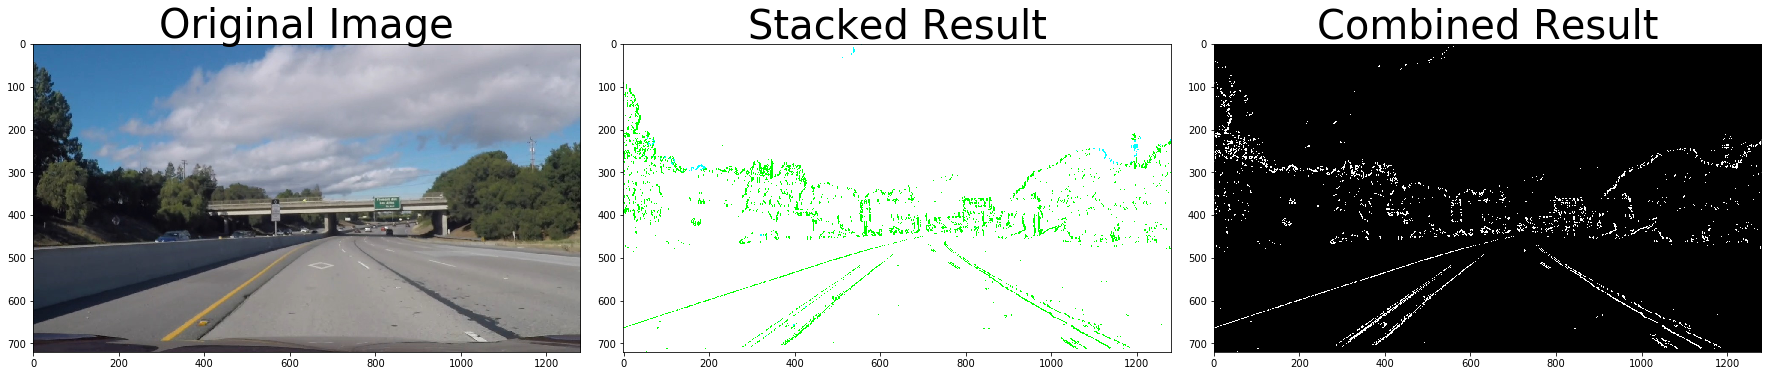

In [11]:
#Code Cell 8
image = mpimg.imread('./test_images/test11.jpg')

# Edit this function to create your own pipeline.
def pipeline(img):
    img = np.copy(img)
    undistorted = camCal.undistortImage(img)


    gradx_g = abs_sobel_thresh(undistorted, orient='x', channel="GRAY", sobel_kernel=ksize, thresh=(20, 160))
    grady_g = abs_sobel_thresh(undistorted, orient='y', channel="GRAY", sobel_kernel=15, thresh=(20, 160))
    mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(15, 100))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    
    gradx_l = abs_sobel_thresh(undistorted, orient='x', channel="HLS_L", sobel_kernel=ksize, thresh=(20, 100))
    gradx_s = abs_sobel_thresh(undistorted, orient='x', channel="HLS_S", sobel_kernel=ksize, thresh=(20, 100))
    gradx_gr = abs_sobel_thresh(undistorted, orient='x', channel="RGB_G", sobel_kernel=ksize, thresh=(210, 255))
    color_s = color_thresh(image, channel="HLS_S", thresh=(100, 255))
    color_l = color_thresh(image, channel="HLS_L", thresh=(220, 255))
    color_gr = color_thresh(image, channel="RGB_G", thresh=(210, 255))

    #color_t = color_thresh(undistorted, channel="HLS_S", thresh=(150,255))


    color_binary = np.dstack(( np.zeros_like(gradx_g), gradx_g, color_s, gradx_g)) * 255
    
    combined_binary = np.zeros_like(gradx)
    #combined_binary[(gradx_l ==1) | (color_t ==1) | (gradx_s==1) ] = 1
    #combined_binary[((gradx_g == 1) & (grady_g == 1) & (gradx_l == 1)) | ((color_s == 1) | (color_l == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined_binary[((gradx_g == 1) & (grady_g == 1) | (gradx_gr == 1)) | ((color_s == 1) | (color_l == 1) | (color_gr == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined_binary[((gradx_g == 1) & (grady_g == 1)) | ((color_s == 1) | (color_v == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined_binary[((gradx_l == 1) & (gradx_s == 1)) | ((color_s == 1) | (color_v == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined_binary[(gradx_g == 1) | (color_s == 1) | (color_v == 1)] = 1


    return color_binary, combined_binary
    
stacked, combined = pipeline(image)
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(stacked, cmap="gray")
ax2.set_title('Stacked Result', fontsize=40)

ax3.imshow(combined, cmap="gray")
ax3.set_title('Combined Result', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

In [58]:
# Code cell 8a

# Test function to experiment and visualize various src and dst points to figure out correct one to use
# for perspective transform

def testTransform():
    simg = mpimg.imread('test_images/straight_lines1.jpg')
    img = np.copy(simg)

    h,w= img.shape[:2]
    
#    src = np.float32(
#        [[683, 448], 
#          [1110, 720], 
#          [210, 720], 
#          [597, 448]])
#
#    dst = np.float32(
#        [[900, 0], 
#          [900, 720], 
#          [250, 720], 
#          [250, 0]])

#    src = np.float32([[580, 450],
#                     [180, 720],
#                     [1120, 720],
#                     [700, 450]])
#
#    dst = np.float32([[350, 0],
#                     [350, 720],
#                     [900, 720],
#                     [900, 0]])

    src = np.float32(
        [[685, 450], 
          [1090, 710], 
          [220, 710], 
          [595, 450]])
    
    dst = np.float32(
        [[900, 0], 
          [900, 710], 
          [250, 710], 
          [250, 0]])
    

    cv2.polylines(img,np.int_([src]), isClosed=True, color=(0,0,255), thickness=4)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    img_size = (w, h)
    warped = cv2.warpPerspective(simg, M, img_size, flags=cv2.INTER_LINEAR)
    #cv2.fillPoly(warped, np.int_([dst]), (128,128, 0))
    cv2.polylines(warped,np.int_([dst]), isClosed=True, color=(0,0,255), thickness=4)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img)
    ax1.set_title('Lanes on Orig', fontsize=40)

    ax2.imshow(warped)
    ax2.set_title('Lanes on Transformed', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    plt.show()
    
testTransform()

720 1280


## Perspective Transform

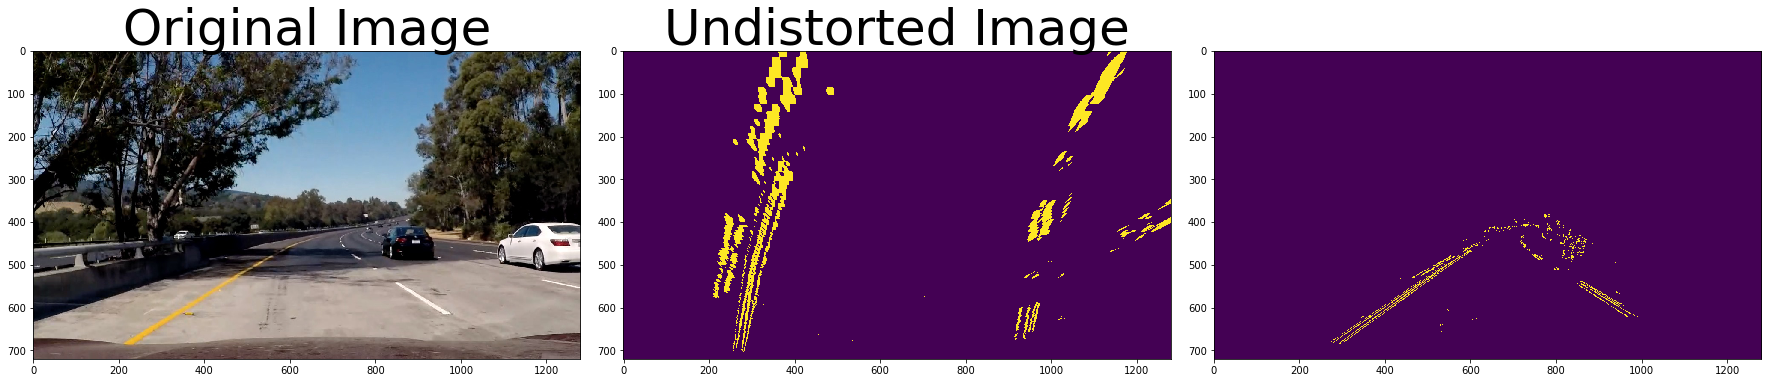

In [59]:
#Code Cell 9
def get_transform_matrix():
    img = mpimg.imread('test_images/straight_lines1.jpg')
    h,w= img.shape[:2]

    src = np.float32(
        [[685, 450], 
          [1090, 710], 
          [220, 710], 
          [595, 450]])
    
    dst = np.float32(
        [[900, 0], 
          [900, 710], 
          [250, 710], 
          [250, 0]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M,Minv

## Leveraging region_of_interest from first project to remove parts of the image 
# between the lanes so as to remove noise.
# Remove a region of an image
def remove_region(img, triangle):
    mask = np.ones_like(img) 
    mask = cv2.fillPoly(mask, [triangle], 0)

    new_combined = np.zeros_like(img)
    new_combined[((img == 1) & (mask == 1))] = 1
    
    return new_combined

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

cal_image = mpimg.imread("./test_images/test5.jpg")

stacked,processed = pipeline(cal_image)

# Remove a piece of the road between te lanes. This removes some noise that may be in between the lane lines
#h,w= processed.shape[:2]
#triangle = np.array([[350, h], [w-300, h], [w//2, 500]], np.int32)
#processed = remove_region(processed, triangle)
pHeightMask=1.7
imshape = cal_image.shape
vertices = np.array([[(0,imshape[0]),(imshape[1]/pHeightMask, imshape[0]/2), (imshape[1]/pHeightMask, imshape[0]/2), (imshape[1],imshape[0])]], dtype=np.int32)
processed = region_of_interest(processed,vertices)
    
M,Minv = get_transform_matrix()
img_size = (processed.shape[1], processed.shape[0])
warped = cv2.warpPerspective(processed, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cal_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Undistorted Image', fontsize=50)
ax3.imshow(processed)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [60]:
#Code Cell 10
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

## Sliding Window Search (CLASS)

In [81]:
#Code Cell 12
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        # polynomial coefficients of the last n fits of the line
        self.recent_fitted = [] 
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = None 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = []  
        #y values for detected line pixels
        self.ally = []
        self.avgx = []
        self.avgy = []
        
    def updateLine_old1(self,fit, fitxPts, fityPts, radius, position):
        resetWindow = False

        if self.radius_of_curvature is None:
            diff = 0.0
        else:
            diff = abs(self.radius_of_curvature - radius)

        if (diff/radius > 0.7):
            # looks like a bad reading
            # Don't add and reset Window
            #print ("Old:",self.current_fit," New:",fit, "Diff:",diff)
            print ("Old:",self.radius_of_curvature," New:",radius, "Diff:",diff)

            resetWindow = True
        else:
            self.radius_of_curvature = radius
            self.diffs = diff
            self.current_fit = np.array(fit)
            self.recent_fitted.append(fit)
            if (len(self.recent_fitted) > 10):
                self.recent_fitted.pop(0)
            self.recent_xfitted.append(fitxPts)
            if (len(self.recent_xfitted) > 10):
                self.recent_xfitted.pop(0)
            llen = len(self.recent_xfitted)
            self.bestx = [float(sum(col))/llen for col in zip(*(self.recent_xfitted))]
            self.best_fit = np.mean(np.array(self.recent_fitted), axis=0)
            self.line_base_pos = position

        return resetWindow
        
    def updateLine(self,fit, fitxPts, fityPts, radius, position):
        resetWindow = False

        if self.current_fit is None:
            diff = np.array([0,0,0], dtype='float')
        else:
            diff = np.absolute(self.current_fit - fit)
            

        #if (abs(diff[0]) > 0.001) | (abs(diff[1]) > 1.) | (abs(diff[2]) > 100.):
        if (abs(diff[0]) > 0.005) | (abs(diff[1]) > 0.5) | (abs(diff[2]) > 50.):

            # looks like a bad reading
            # Don't add and reset Window
            print ("Old:",self.current_fit," New:",fit, "Diff:",diff)
            #print ("Old:",self.radius_of_curvature," New:",radius, "Diff:",diff)

            resetWindow = True
        else:
            self.radius_of_curvature = radius
            self.diffs = diff
            self.current_fit = np.array(fit)
            self.recent_fitted.append(fit)
            if (len(self.recent_fitted) > 10):
                self.recent_fitted.pop(0)
            self.recent_xfitted.append(fitxPts)
            if (len(self.recent_xfitted) > 10):
                self.recent_xfitted.pop(0)
            llen = len(self.recent_xfitted)
            self.bestx = [float(sum(col))/llen for col in zip(*(self.recent_xfitted))]
            self.best_fit = np.mean(np.array(self.recent_fitted), axis=0)
            self.line_base_pos = position

        return resetWindow

    def updateLine_old(self,fit, fitxPts, fityPts, radius, position):
        resetWindow = False

        if self.current_fit is None:
            diff = np.array([0,0,0], dtype='float')
        else:
            diff = np.absolute(self.current_fit - fit)

        if (abs(diff[0]/fit[0]) > 0.3) | (abs(diff[1]/fit[1]) > 0.3) | (abs(diff[2]/fit[2]) > 0.3):
            # looks like a bad reading
            # Don't add and reset Window
            #print ("Old:",self.current_fit," New:",fit, "Diff:",diff)
            resetWindow = True
        else:
            self.diffs = diff
            self.current_fit = np.array(fit)
            self.recent_fitted.append(fit)
            if (len(self.recent_fitted) > 5):
                self.recent_fitted.pop(0)
            self.best_fit = np.mean(np.array(self.recent_fitted), axis=0)
            self.line_base_pos = position
            
        return resetWindow

class SlidingWindow():
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    
    def __init__(self):
        self.leftLine = Line()
        self.rightLine = Line()
        #self.first_pass = True
        self.resetWindowParams ()
        return

    def resetWindowParams(self):
        print ("First Pass")
        self.leftLine = Line()
        self.rightLine = Line()
        self.left_lane_inds = []
        self.right_lane_inds = []
        self.left_fit, self.right_fit, self.left_fitx, self.right_fitx, self.ploty = None,None,None,None,None
        self.left_fit_cr, self.right_fit_cr = None, None
        self.nonzeroy, self.nonzerox = None, None
        return

    def polyfit(self,binary_warped):
        resetWindow = False
        if self.leftLine.detected == False | self.rightLine.detected == False:
            #print ("Polyfit: First Pass")
            self.resetWindowParams()
            #self.first_pass = False
            out_img = self.sliding_window_polyfit(binary_warped)
            self.leftLine.detected = self.rightLine.detected = True
        else:
            #print ("Polyfit: subsequent Pass")
            out_img =  self.no_sliding_polyfit(binary_warped)
            
        left_curverad, right_curverad= self.calc_curve()
        #print(left_curverad, 'm', right_curverad, 'm')
        position = self.calc_lane_position(binary_warped)
        resetWindow |= self.leftLine.updateLine(self.left_fit, self.left_fitx, self.ploty, left_curverad, position)
        resetWindow |= self.rightLine.updateLine(self.right_fit, self.right_fitx, self.ploty, right_curverad, position)

        
        if resetWindow == True:
            #self.first_pass = True
            self.leftLine.detected = self.rightLine.detected = False

            # Reset Window search
            #print ("Resetting Window search....")
            #self.resetWindowParams()
            #out_img = self.sliding_window_polyfit(binary_warped)
            #left_curverad, right_curverad= self.calc_curve()
            #position = self.calc_lane_position(binary_warped)

            #resetWindow |= self.leftLine.updateLine(self.left_fit, self.left_fitx, self.ploty, left_curverad, position)
            #resetWindow |= self.rightLine.updateLine(self.right_fit, self.right_fitx, self.ploty, right_curverad, position)
        return out_img
    
    def polyfit_old(self,binary_warped):
        resetWindow = False
        if self.first_pass:
            #print ("Polyfit: First Pass")
            self.resetWindowParams()
            self.first_pass = False
            out_img = self.sliding_window_polyfit(binary_warped)
            resetWindow |= self.leftLine.updateLine(self.left_fit, self.left_fitx, self.ploty, 0, 0)
            resetWindow |= self.rightLine.updateLine(self.right_fit, self.right_fitx, self.ploty, 0, 0)
        else:
            #print ("Polyfit: subsequent Pass")
            out_img =  self.no_sliding_polyfit(binary_warped)
            resetWindow |= self.leftLine.updateLine(self.left_fit, self.left_fitx, self.ploty, 0, 0)
            resetWindow |= self.rightLine.updateLine(self.right_fit, self.right_fitx, self.ploty, 0, 0)
        
        if resetWindow == True:
            # Reset Window search
            #print ("Resetting Window search....")
            self.resetWindowParams()
            out_img = self.sliding_window_polyfit(binary_warped)
            resetWindow |= self.leftLine.updateLine(self.left_fit, self.left_fitx, self.ploty, 0, 0)
            resetWindow |= self.rightLine.updateLine(self.right_fit, self.right_fitx, self.ploty, 0, 0)
        return out_img

    def sliding_window_polyfit(self,binary_warped):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        self.left_lane_inds = []
        self.right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - self.margin
            win_xleft_high = leftx_current + self.margin
            win_xright_low = rightx_current - self.margin
            win_xright_high = rightx_current + self.margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            self.left_lane_inds.append(good_left_inds)
            self.right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > self.minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > self.minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        self.left_lane_inds = np.concatenate(self.left_lane_inds)
        self.right_lane_inds = np.concatenate(self.right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[self.left_lane_inds]
        lefty = nonzeroy[self.left_lane_inds] 
        rightx = nonzerox[self.right_lane_inds]
        righty = nonzeroy[self.right_lane_inds]


        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        # Fit new polynomials to x,y in world space
        self.left_fit_cr = np.polyfit(lefty*self.ym_per_pix, leftx*self.xm_per_pix, 2)
        self.right_fit_cr = np.polyfit(righty*self.ym_per_pix, rightx*self.xm_per_pix, 2)
        # Generate x and y values for plotting
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]

        self.nonzerox = nonzerox
        self.nonzeroy = nonzeroy
        return out_img

    def plot_windows(self,binary_warped, out_img, ax):
        # Generate x and y values for plotting
        #self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        #self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        #self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]

        out_img[self.nonzeroy[self.left_lane_inds], self.nonzerox[self.left_lane_inds]] = [255, 0, 0]
        out_img[self.nonzeroy[self.right_lane_inds], self.nonzerox[self.right_lane_inds]] = [0, 0, 255]
        ax.imshow(out_img)
        ax.plot(self.left_fitx, self.ploty, color='yellow')
        ax.plot(self.right_fitx, self.ploty, color='yellow')
        #plt.xlim(0, 1280)
        #plt.ylim(720, 0)
        #plt.show()
        
    def no_sliding_polyfit(self, binary_warped):
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        self.left_lane_inds = ((nonzerox > (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + 
        self.left_fit[2] - self.margin)) & (nonzerox < (self.left_fit[0]*(nonzeroy**2) + 
        self.left_fit[1]*nonzeroy + self.left_fit[2] + self.margin))) 

        self.right_lane_inds = ((nonzerox > (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + 
        self.right_fit[2] - self.margin)) & (nonzerox < (self.right_fit[0]*(nonzeroy**2) + 
        self.right_fit[1]*nonzeroy + self.right_fit[2] + self.margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[self.left_lane_inds]
        lefty = nonzeroy[self.left_lane_inds] 
        rightx = nonzerox[self.right_lane_inds]
        righty = nonzeroy[self.right_lane_inds]
        
        # Debug code to deal with no leftx points crash
        #if len(leftx) <= 0:
        #    print ("No zero leftX")
        #    print (leftx, rightx)
        #    print (self.left_lane_inds, self.right_lane_inds)
        #    mpimg.imsave("./output_images/binary_warped.jpg",binary_warped)
            
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        # Fit new polynomials to x,y in world space
        self.left_fit_cr = np.polyfit(lefty*self.ym_per_pix, leftx*self.xm_per_pix, 2)
        self.right_fit_cr = np.polyfit(righty*self.ym_per_pix, rightx*self.xm_per_pix, 2)
        self.nonzerox = nonzerox
        self.nonzeroy = nonzeroy
        
        # Generate x and y values for plotting
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]
        
        out_img[self.nonzeroy[self.left_lane_inds], self.nonzerox[self.left_lane_inds]] = [255, 0, 0]
        out_img[self.nonzeroy[self.right_lane_inds], self.nonzerox[self.right_lane_inds]] = [0, 0, 255]
        return out_img
        #plt.imshow(out_img)
        #plt.plot(self.left_fitx, self.ploty, color='yellow')
        #plt.plot(self.right_fitx, self.ploty, color='yellow')
        #plt.xlim(0, 1280)
        #plt.ylim(720, 0)
        #plt.show()

    def calc_lane_position(self, image):
        center_pos = image.shape[1]/2.0
        lane_pos = (self.left_fitx[::-1][0] + self.right_fitx[::-2][0]) / 2.0
        return abs (lane_pos - center_pos) * self.xm_per_pix
    
    def calc_curve(self):
        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(self.ploty)
        left_curverad = ((1 + (2*self.left_fit[0]*y_eval + self.left_fit[1])**2)**1.5) / np.absolute(2*self.left_fit[0])
        right_curverad = ((1 + (2*self.right_fit[0]*y_eval + self.right_fit[1])**2)**1.5) / np.absolute(2*self.right_fit[0])
        #print(left_curverad, right_curverad)


        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*self.left_fit_cr[0]*y_eval*self.ym_per_pix + self.left_fit_cr[1])**2)**1.5) / \
                        np.absolute(2*self.left_fit_cr[0])
        right_curverad = ((1 + (2*self.right_fit_cr[0]*y_eval*self.ym_per_pix + self.right_fit_cr[1])**2)**1.5) / \
                        np.absolute(2*self.right_fit_cr[0])
        # Now our radius of curvature is in meters
        return left_curverad, right_curverad


    def plot_poly(self, binary_warped,ax):
        # Generate x and y values for plotting
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)

        # Color in left and right line pixels
        out_img[self.nonzeroy[self.left_lane_inds], self.nonzerox[self.left_lane_inds]] = [255, 0, 0]
        out_img[self.nonzeroy[self.right_lane_inds], self.nonzerox[self.right_lane_inds]] = [0, 0, 255]
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([self.left_fitx-self.margin, self.ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.left_fitx+self.margin, 
                                      self.ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([self.right_fitx-self.margin, self.ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.right_fitx+self.margin, 
                                      self.ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        ax.imshow(result)
        ax.plot(self.left_fitx, self.ploty, color='yellow')
        ax.plot(self.right_fitx, self.ploty, color='yellow')
        #ax.xlim(0, 1280)
        #ax.ylim(720, 0)
        
    def drawLane(self,warped,image, Minv):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        best_left_fit = self.leftLine.best_fit
        best_right_fit = self.rightLine.best_fit
        best_left_fitx = best_left_fit[0]*self.ploty**2 + best_left_fit[1]*self.ploty + best_left_fit[2]
        best_right_fitx = best_right_fit[0]*self.ploty**2 + best_right_fit[1]*self.ploty + best_right_fit[2]
        #print (best_left_fit,best_right_fit)
        #
        best_leftx = self.leftLine.bestx
        best_rightx = self.rightLine.bestx
        best_left_fit = np.polyfit(self.ploty, best_leftx, 2)
        best_right_fit = np.polyfit(self.ploty, best_rightx, 2)
        #print (best_left_fit,best_right_fit)

        best_left_fitx = best_left_fit[0]*self.ploty**2 + best_left_fit[1]*self.ploty + best_left_fit[2]
        best_right_fitx = best_right_fit[0]*self.ploty**2 + best_right_fit[1]*self.ploty + best_right_fit[2]
        #    
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([best_left_fitx, self.ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([best_right_fitx, self.ploty])))])
        pts = np.hstack((pts_left, pts_right))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        return result

    def drawData(self,image):
        font = cv2.FONT_HERSHEY_PLAIN
        text = "Radius: %.2f km" % ((self.leftLine.radius_of_curvature + self.rightLine.radius_of_curvature)/2000.0)
        cv2.putText(image,text,(30,50),font, 2, (0,0,255), 2, cv2.LINE_AA)
        text = "Position: %.2f m" % (self.leftLine.line_base_pos)
        cv2.putText(image,text,(1000,50),font, 2, (0,0,255), 2, cv2.LINE_AA)

        return image
        


First Pass


658.9797737456065 m 600.0266356446372 m


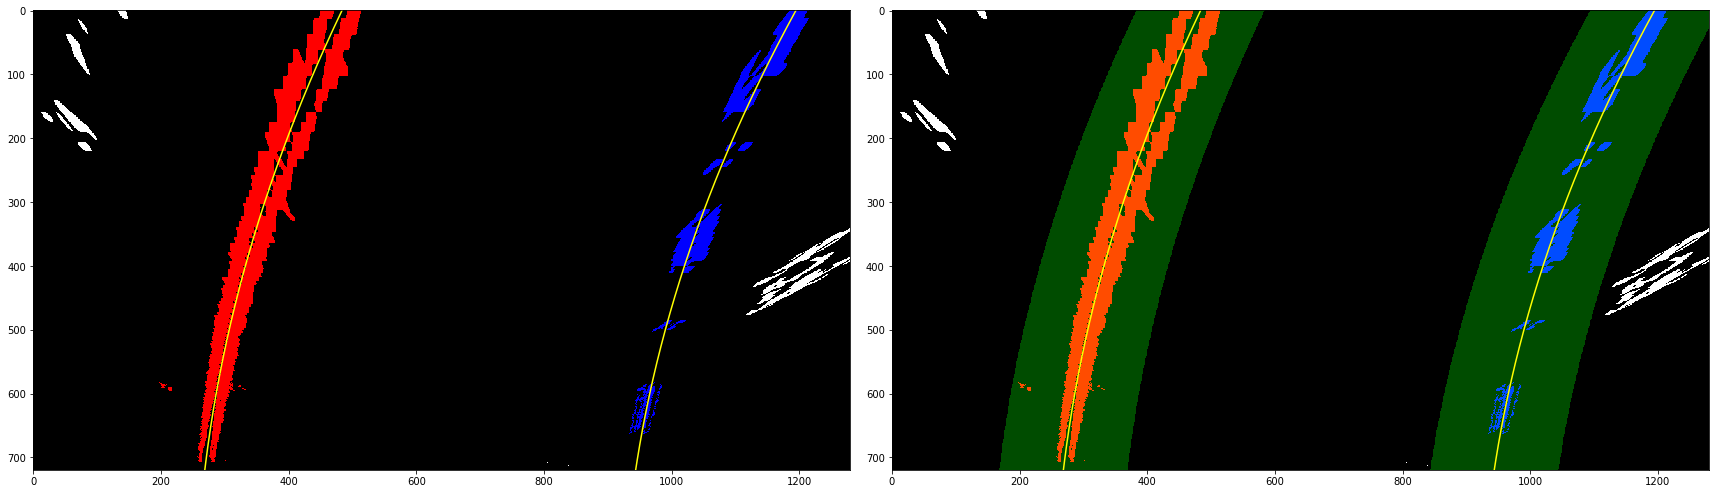

658.9797737456859 m 600.0266356443271 m


In [82]:
#Code Cell 13
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()        
binary_warped = np.copy(warped)
slideW = SlidingWindow()
out_img = slideW.sliding_window_polyfit(binary_warped)
slideW.plot_windows(binary_warped,out_img, ax1)


result = slideW.plot_poly(binary_warped,ax2)


plt.show()

left_curverad, right_curverad= slideW.calc_curve()

print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

image = mpimg.imread('./test_images/test6.jpg')
stacked, combined = pipeline(image)

M,Minv = get_transform_matrix()
img_size = (processed.shape[1], processed.shape[0])
warped = cv2.warpPerspective(processed, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()       
binary_warped = np.copy(warped)

out_img = slideW.no_sliding_polyfit(binary_warped)
slideW.plot_windows(binary_warped,out_img,ax1)


result = slideW.plot_poly(binary_warped,ax2)

plt.show()

left_curverad, right_curverad= slideW.calc_curve()

print(left_curverad, 'm', right_curverad, 'm')

First Pass
./output_images/test0.jpg
First Pass


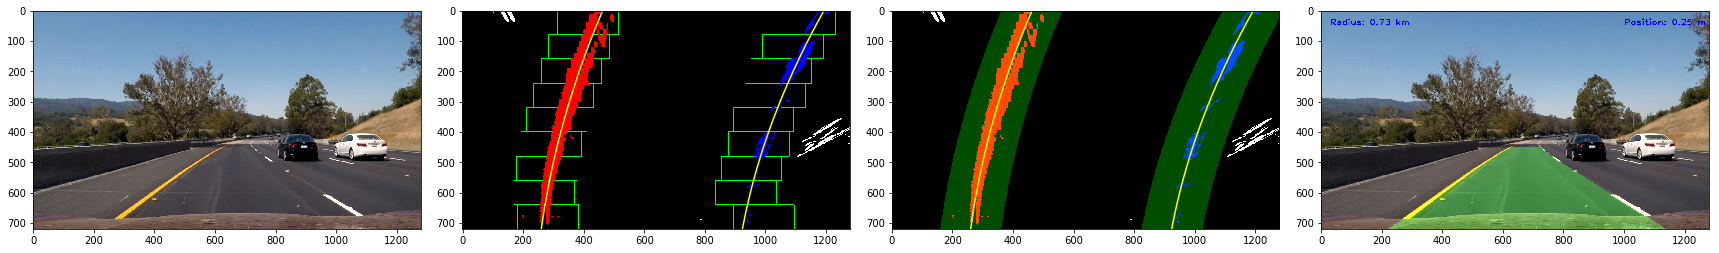

815.7533034540378 m 637.7272700980262 m
./output_images/test1.jpg


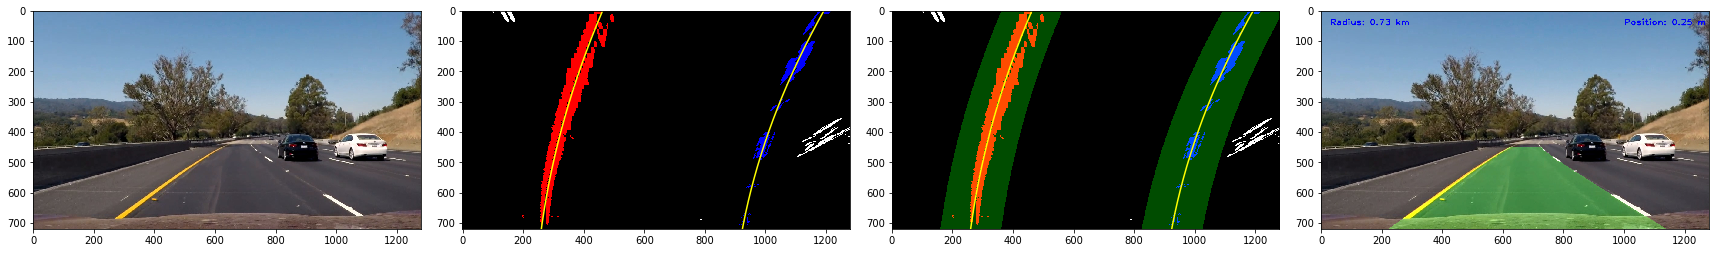

815.753303453924 m 637.7272700979049 m
./output_images/test2.jpg


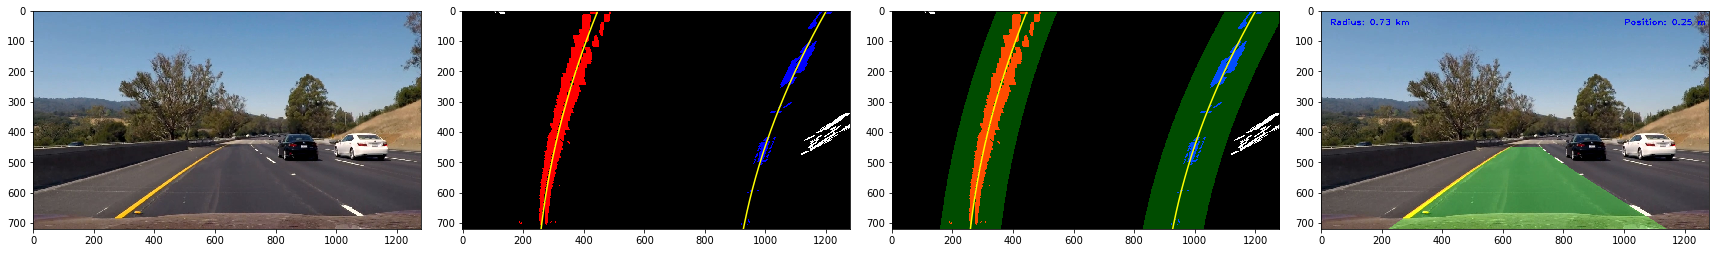

825.005837136554 m 634.3199813446919 m
./output_images/test3.jpg


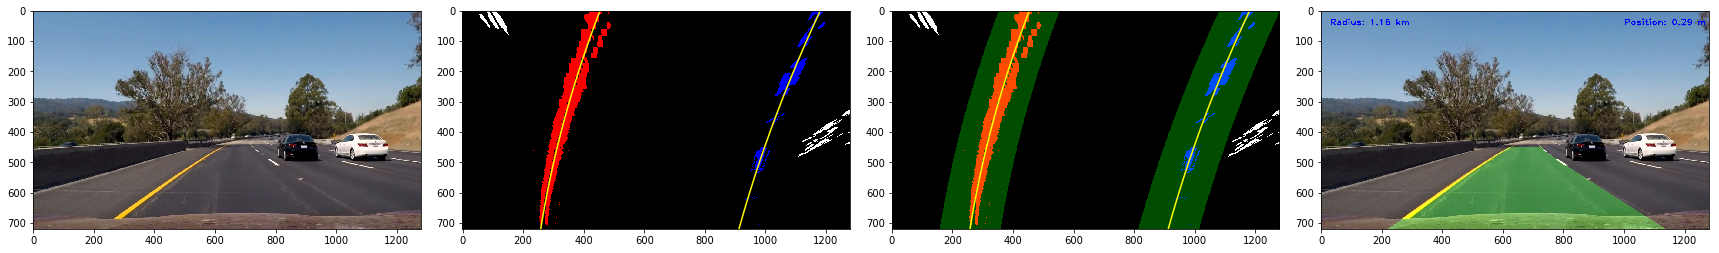

1065.1545859461335 m 1255.9121912139033 m
./output_images/test4.jpg


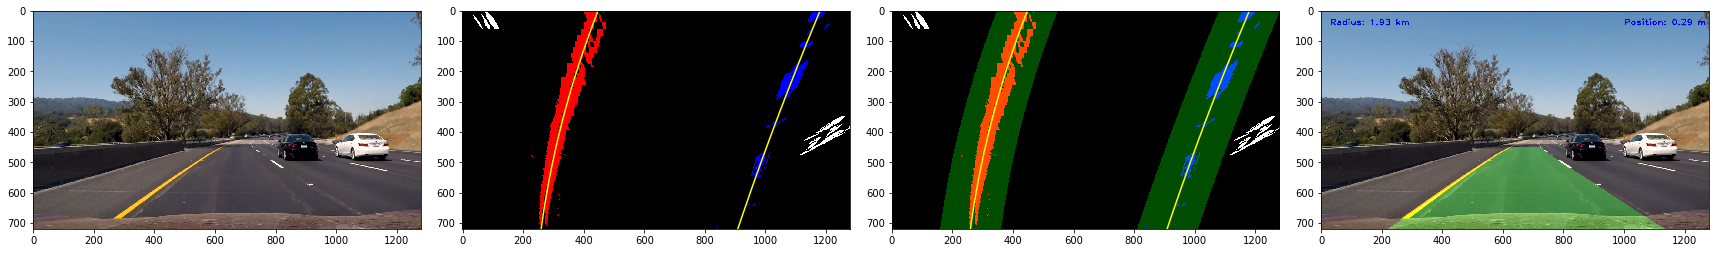

925.3504498294519 m 2941.55220329798 m
./output_images/test5.jpg


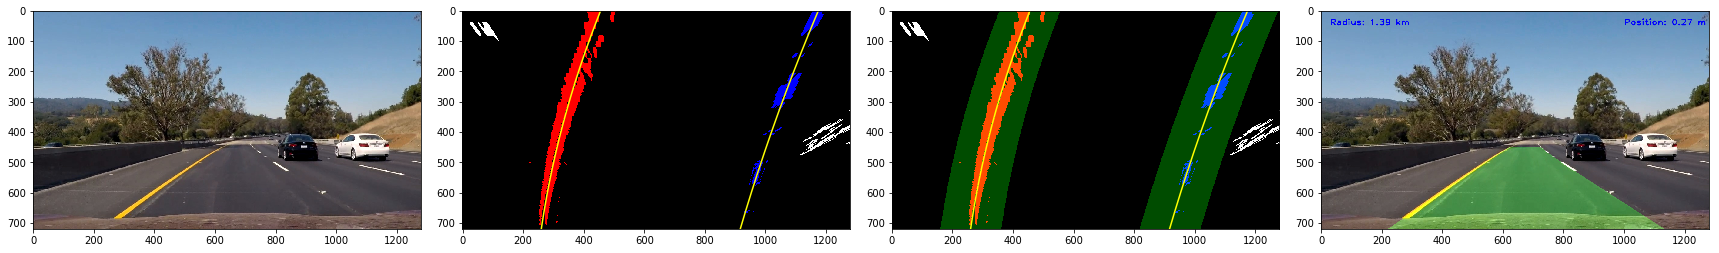

940.1534292169113 m 1844.7642844187721 m
./output_images/test6.jpg


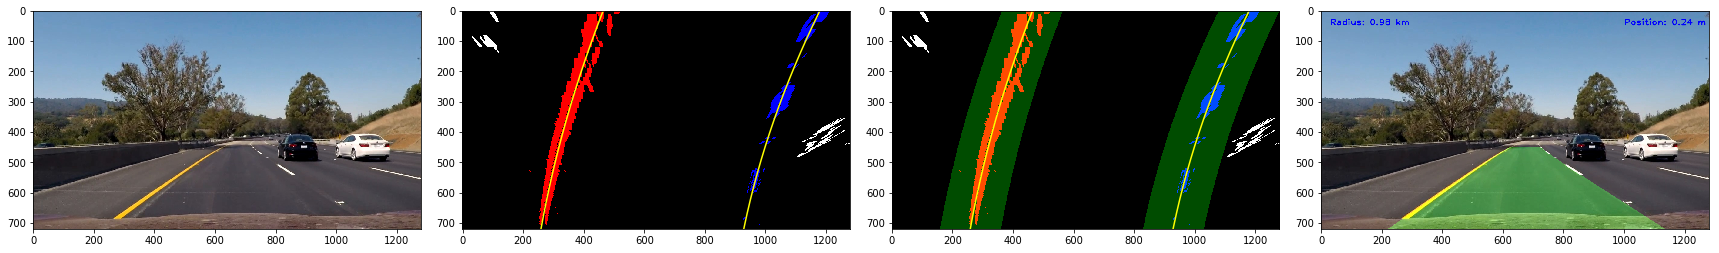

1131.9547564158038 m 833.1907433483476 m
./output_images/test7.jpg


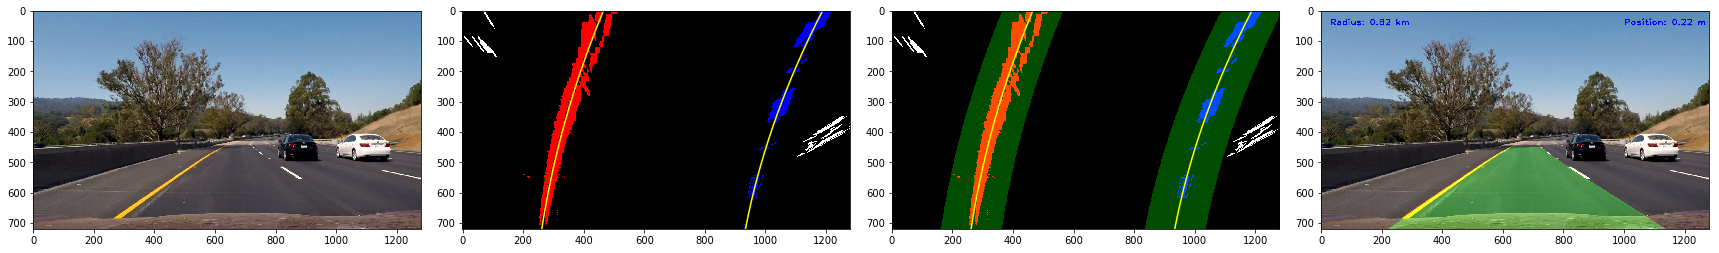

909.3753284022616 m 735.8481338571036 m
./output_images/test8.jpg


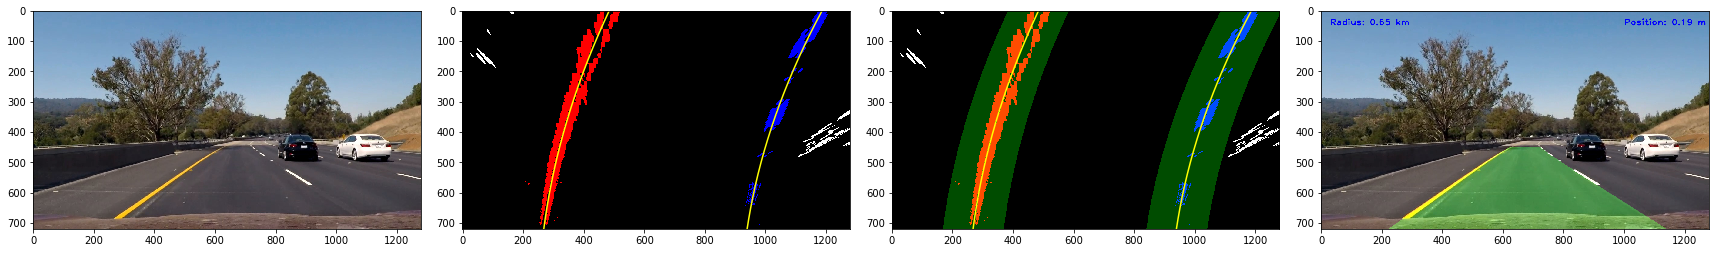

695.5852691528729 m 612.8506847419437 m
./output_images/test9.jpg


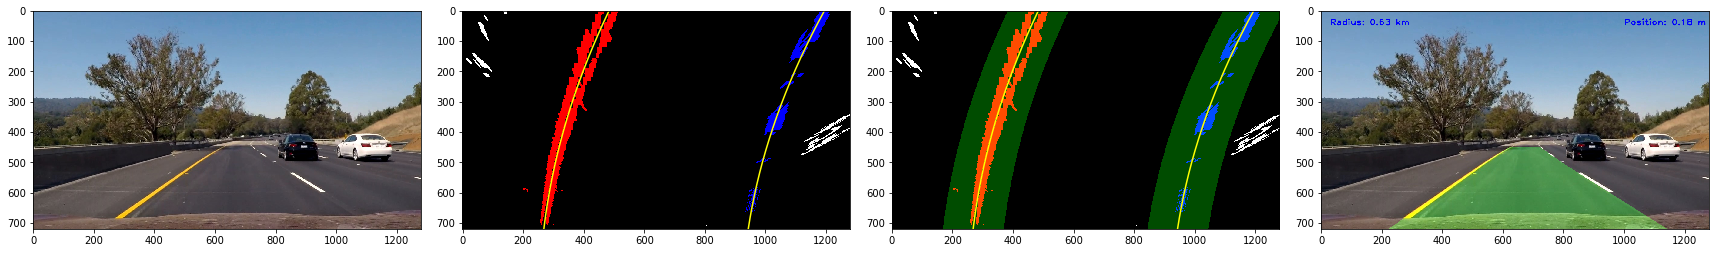

658.9797737456859 m 602.1397815290003 m


In [83]:
#Code Cell 14
images = glob.glob("./test_images/test*.jpg")

slide = SlidingWindow()
for n in range(0,10):

    fname = "./output_images/test%d.jpg" % n
    print (fname)
    image = mpimg.imread(fname)
    stacked, processed = pipeline(image)
    
    h,w= processed.shape[:2]
    triangle = np.array([[350, h], [w-300, h], [w//2, 500]], np.int32)
    processed = remove_region(processed, triangle)
    
    M,Minv = get_transform_matrix()
    img_size = (processed.shape[1], processed.shape[0])
    warped = cv2.warpPerspective(processed, M, img_size, flags=cv2.INTER_LINEAR)

    f, ax = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout() 
    ax[0].imshow(image)
    binary_warped = np.copy(warped)

    out_img = slide.polyfit(binary_warped)

    slide.plot_windows(binary_warped,out_img,ax[1])

    result = slide.plot_poly(binary_warped,ax[2])

    lanes = slide.drawLane(binary_warped,image,Minv)
    lanes = slide.drawData(lanes)

    ax[3].imshow(lanes)

    plt.show()

    left_curverad, right_curverad= slide.calc_curve()

    print(left_curverad, 'm', right_curverad, 'm')

In [84]:
#Code Cell 15

videoSlide = SlidingWindow()

def process_image(image):
    #fname = "./output_images/test%d.jpg" % process_image.imgFile
    #process_image.imgFile += 1
    #mpimg.imsave(fname,image)
    stacked, processed = pipeline(image)
    
    h,w= processed.shape[:2]
    triangle = np.array([[350, h], [w-300, h], [w//2, 500]], np.int32)
    processed = remove_region(processed, triangle)
    
    M,Minv = get_transform_matrix()
    img_size = (processed.shape[1], processed.shape[0])
    warped = cv2.warpPerspective(processed, M, img_size, flags=cv2.INTER_LINEAR)

    binary_warped = np.copy(warped)

    out_img = videoSlide.polyfit(binary_warped)

    lanes = videoSlide.drawLane(binary_warped,image,Minv)

    lanes = videoSlide.drawData(lanes)
    return lanes

process_image.imgFile = 0


First Pass


In [85]:
#Code Cell 16
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(38,41)
clip1 = VideoFileClip("project_video.mp4")
#clip1 = clip1.set_start(19.0)
#clip1 = clip1.set_duration(7.0)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

First Pass
[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


  2%|▏         | 31/1261 [00:09<06:41,  3.07it/s]

Old: [-1.83643579e-04  4.50591329e-01  7.51065430e+02]  New: [-5.87723965e-04  7.86984615e-01  6.86458045e+02] Diff: [4.04080386e-04 3.36393285e-01 6.46073847e+01]


  3%|▎         | 32/1261 [00:10<06:37,  3.09it/s]

First Pass


 13%|█▎        | 165/1261 [00:53<05:56,  3.08it/s]

Old: [-3.90880839e-04  6.65818975e-01  6.83066227e+02]  New: [-7.25384225e-04  9.65764041e-01  6.17127223e+02] Diff: [3.34503386e-04 2.99945066e-01 6.59390043e+01]


 13%|█▎        | 166/1261 [00:53<05:53,  3.10it/s]

First Pass


 13%|█▎        | 167/1261 [00:53<05:49,  3.13it/s]

Old: [-3.46753471e-04  6.47439756e-01  6.75041437e+02]  New: [-5.83878001e-04  8.85557114e-01  6.16120172e+02] Diff: [2.37124530e-04 2.38117358e-01 5.89212648e+01]


 13%|█▎        | 168/1261 [00:54<05:49,  3.13it/s]

First Pass


 15%|█▍        | 186/1261 [00:59<05:48,  3.09it/s]

Old: [-5.96596685e-04  9.63131223e-01  5.80151767e+02]  New: [-7.17886996e-04  1.11785562e+00  5.25735456e+02] Diff: [1.21290311e-04 1.54724398e-01 5.44163109e+01]


 15%|█▍        | 187/1261 [01:00<05:49,  3.08it/s]

First Pass


 15%|█▍        | 188/1261 [01:00<05:49,  3.07it/s]

Old: [-3.42783837e-04  7.98885382e-01  5.84967164e+02]  New: [-6.00157886e-04  1.04369313e+00  5.27650024e+02] Diff: [2.57374049e-04 2.44807751e-01 5.73171398e+01]


 15%|█▍        | 189/1261 [01:00<05:47,  3.08it/s]

First Pass


 16%|█▌        | 196/1261 [01:03<05:35,  3.17it/s]

Old: [-6.49218878e-04  1.03815296e+00  5.44256429e+02]  New: [-4.07414672e-04  7.85363491e-01  6.18750733e+02] Diff: [2.41804207e-04 2.52789465e-01 7.44943039e+01]


 16%|█▌        | 197/1261 [01:03<05:36,  3.16it/s]

First Pass


 19%|█▊        | 236/1261 [01:15<05:22,  3.18it/s]

Old: [-2.75478450e-04  6.31981786e-01  6.48971915e+02]  New: [-5.32202253e-04  8.72311581e-01  5.89601608e+02] Diff: [2.56723803e-04 2.40329795e-01 5.93703068e+01]


 19%|█▉        | 237/1261 [01:15<05:22,  3.17it/s]

First Pass


 19%|█▉        | 238/1261 [01:16<05:23,  3.17it/s]

Old: [-3.01211961e-04  6.85498282e-01  6.23150811e+02]  New: [-6.42293083e-04  9.83256897e-01  5.62319658e+02] Diff: [3.41081122e-04 2.97758616e-01 6.08311529e+01]


 19%|█▉        | 239/1261 [01:16<05:23,  3.16it/s]

First Pass


 42%|████▏     | 530/1261 [02:50<03:58,  3.07it/s]

Old: [-4.64442829e-04  3.70373761e-01  2.16487505e+02]  New: [-1.74108405e-04  8.71199355e-02  2.85155443e+02] Diff: [2.90334424e-04 2.83253825e-01 6.86679379e+01]


 42%|████▏     | 531/1261 [02:50<03:57,  3.07it/s]

First Pass


 42%|████▏     | 532/1261 [02:50<03:58,  3.05it/s]

Old: [ 1.88518467e-04 -2.83853497e-01  3.77908714e+02]  New: [ 3.45485960e-04 -4.71063965e-01  4.35153725e+02] Diff: [1.56967493e-04 1.87210468e-01 5.72450117e+01]


 42%|████▏     | 533/1261 [02:51<03:59,  3.04it/s]

First Pass


 44%|████▍     | 560/1261 [02:59<03:46,  3.10it/s]

Old: [-1.78844528e-04 -5.47175863e-02  1.04045260e+03]  New: [ 1.03224314e-04 -3.81036878e-01  1.14752304e+03] Diff: [2.82068842e-04 3.26319291e-01 1.07070438e+02]


 44%|████▍     | 561/1261 [03:00<03:47,  3.08it/s]

First Pass


 45%|████▍     | 563/1261 [03:00<03:43,  3.12it/s]

Old: [ 2.10617399e-04 -5.15078275e-01  1.20570558e+03]  New: [ 5.74486191e-05 -2.93644435e-01  1.12258028e+03] Diff: [1.53168779e-04 2.21433840e-01 8.31252976e+01]


 45%|████▍     | 564/1261 [03:01<03:42,  3.13it/s]

First Pass


 45%|████▍     | 565/1261 [03:01<03:40,  3.16it/s]

Old: [ 4.08935842e-05 -1.61276166e-01  1.04478107e+03]  New: [-2.84917201e-04  1.62778662e-01  9.59725066e+02] Diff: [3.25810785e-04 3.24054828e-01 8.50560045e+01]


 45%|████▍     | 566/1261 [03:01<03:40,  3.15it/s]

First Pass


 48%|████▊     | 606/1261 [03:14<03:27,  3.16it/s]

Old: [ 1.66862861e-04 -3.88707078e-01  4.61909395e+02]  New: [ 4.83696297e-05 -1.61467602e-01  3.73070224e+02] Diff: [1.18493231e-04 2.27239476e-01 8.88391719e+01]


 48%|████▊     | 607/1261 [03:15<03:28,  3.14it/s]

First Pass


 50%|████▉     | 625/1261 [03:20<03:23,  3.12it/s]

Old: [ 4.78234916e-04 -7.13916867e-01  5.17696913e+02]  New: [ 5.03735974e-04 -8.18832026e-01  5.77612749e+02] Diff: [2.55010573e-05 1.04915159e-01 5.99158364e+01]


 50%|████▉     | 626/1261 [03:21<03:23,  3.12it/s]

First Pass


 50%|████▉     | 630/1261 [03:22<03:22,  3.11it/s]

Old: [ 5.72257900e-04 -9.19518215e-01  6.21555588e+02]  New: [ 4.63445347e-04 -7.55140029e-01  5.57882358e+02] Diff: [1.08812553e-04 1.64378186e-01 6.36732305e+01]


 50%|█████     | 631/1261 [03:22<03:24,  3.08it/s]

First Pass


 51%|█████     | 637/1261 [03:24<03:17,  3.16it/s]

Old: [ 3.32044692e-04 -6.81909360e-01  5.66737415e+02]  New: [ 4.67777334e-04 -8.46410187e-01  6.23298777e+02] Diff: [1.35732642e-04 1.64500827e-01 5.65613616e+01]


 51%|█████     | 638/1261 [03:25<03:18,  3.13it/s]

First Pass


 51%|█████     | 640/1261 [03:25<03:19,  3.11it/s]

Old: [ 5.00821479e-04 -8.50673135e-01  6.15373484e+02]  New: [ 3.74372747e-04 -6.90755315e-01  5.62069644e+02] Diff: [1.26448731e-04 1.59917820e-01 5.33038392e+01]


 51%|█████     | 641/1261 [03:25<03:19,  3.10it/s]

First Pass


 80%|███████▉  | 1006/1261 [05:23<01:18,  3.24it/s]

Old: [ 4.11844382e-04 -6.56144550e-01  1.21649507e+03]  New: [ 3.33321859e-04 -5.28080214e-01  1.15633720e+03] Diff: [7.85225229e-05 1.28064336e-01 6.01578687e+01]


 80%|███████▉  | 1007/1261 [05:23<01:18,  3.24it/s]

First Pass


 81%|████████  | 1018/1261 [05:26<01:15,  3.22it/s]

Old: [ 1.09735936e-04 -3.54503677e-01  4.61569632e+02]  New: [-1.47275515e-04 -1.05611873e-01  4.05205136e+02] Diff: [2.57011452e-04 2.48891804e-01 5.63644966e+01]


 81%|████████  | 1019/1261 [05:27<01:15,  3.22it/s]

First Pass


 81%|████████▏ | 1026/1261 [05:29<01:13,  3.18it/s]

Old: [-1.58629598e-04  1.11543643e-01  2.88752301e+02]  New: [ 9.97724072e-05 -1.45538326e-01  3.44662668e+02] Diff: [2.58402005e-04 2.57081969e-01 5.59103671e+01]


 81%|████████▏ | 1027/1261 [05:29<01:13,  3.18it/s]

First Pass


 82%|████████▏ | 1036/1261 [05:32<01:12,  3.10it/s]

Old: [ 2.41103635e-04 -4.15248867e-01  4.34995869e+02]  New: [ 4.01521232e-04 -5.98428145e-01  4.87666325e+02] Diff: [1.60417597e-04 1.83179278e-01 5.26704553e+01]


 82%|████████▏ | 1037/1261 [05:33<01:12,  3.11it/s]

First Pass


 83%|████████▎ | 1045/1261 [05:35<01:11,  3.04it/s]

Old: [ 4.15453952e-04 -5.97825427e-01  4.78501264e+02]  New: [ 3.11832427e-04 -4.55447988e-01  4.27158290e+02] Diff: [1.03621525e-04 1.42377439e-01 5.13429737e+01]


 83%|████████▎ | 1046/1261 [05:35<01:10,  3.06it/s]

First Pass


 83%|████████▎ | 1048/1261 [05:36<01:09,  3.08it/s]

Old: [ 3.68671024e-04 -5.67439041e-01  4.73017519e+02]  New: [ 2.66883879e-04 -4.23843050e-01  4.17916397e+02] Diff: [1.01787145e-04 1.43595991e-01 5.51011224e+01]


 83%|████████▎ | 1049/1261 [05:36<01:09,  3.07it/s]

First Pass


 84%|████████▎ | 1054/1261 [05:38<01:06,  3.11it/s]

Old: [ 1.11143114e-04 -3.21224582e-01  4.03958269e+02]  New: [ 2.11220707e-04 -4.72597380e-01  4.66060794e+02] Diff: [1.00077593e-04 1.51372797e-01 6.21025252e+01]


 84%|████████▎ | 1055/1261 [05:38<01:05,  3.13it/s]

First Pass


 84%|████████▍ | 1063/1261 [05:41<01:02,  3.19it/s]

Old: [ 4.65941146e-04 -7.95025646e-01  5.98921317e+02]  New: [ 3.11472007e-04 -6.04489097e-01  5.36629159e+02] Diff: [1.54469140e-04 1.90536549e-01 6.22921576e+01]


 84%|████████▍ | 1064/1261 [05:41<01:01,  3.19it/s]

First Pass


100%|█████████▉| 1260/1261 [06:45<00:00,  2.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 7min 34s, sys: 1min 37s, total: 9min 12s
Wall time: 6min 45s


In [18]:
#Code Cell 17
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'test_videos_output/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
#clip1 = clip1.set_start(0.0)
#clip1 = clip1.set_duration(4.0)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Old: [-2.22166608e-04  1.11705406e-01  3.18005633e+02]  New: [ 4.22253259e-04 -5.08576144e-01  4.67295106e+02] Diff: [6.44419867e-04 6.20281551e-01 1.49289473e+02]
[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4


  0%|          | 1/485 [00:00<02:59,  2.70it/s]

First Pass


  2%|▏         | 12/485 [00:04<02:34,  3.05it/s]

Old: [-6.89755250e-05 -7.31097782e-02  9.87797977e+02]  New: [-3.05603891e-04  1.66968823e-01  9.32408669e+02] Diff: [2.36628366e-04 2.40078602e-01 5.53893078e+01]


  3%|▎         | 13/485 [00:04<02:34,  3.05it/s]

First Pass


 11%|█         | 53/485 [00:17<02:22,  3.03it/s]

Old: [-1.30630915e-03  1.17290679e+00  7.74578453e+02]  New: [-1.56197008e-03  1.41934592e+00  7.20704161e+02] Diff: [2.55660930e-04 2.46439126e-01 5.38742917e+01]


 11%|█         | 54/485 [00:17<02:19,  3.09it/s]

First Pass


 12%|█▏        | 56/485 [00:18<02:20,  3.06it/s]

Old: [ 2.89958882e-05 -3.40432061e-01  1.20451538e+03]  New: [ 2.99478420e-04 -6.08066141e-01  1.26901619e+03] Diff: [2.70482532e-04 2.67634080e-01 6.45008115e+01]


 12%|█▏        | 57/485 [00:18<02:17,  3.11it/s]

First Pass


 12%|█▏        | 58/485 [00:18<02:15,  3.14it/s]

Old: [-6.54619556e-05 -2.19745252e-01  1.16803876e+03]  New: [ 1.98113517e-04 -5.16290367e-01  1.25386900e+03] Diff: [2.63575472e-04 2.96545115e-01 8.58302403e+01]


 12%|█▏        | 59/485 [00:19<02:15,  3.15it/s]

First Pass


 13%|█▎        | 64/485 [00:20<02:13,  3.15it/s]

Old: [3.35418219e-04 8.62259192e-03 7.90624174e+02]  New: [ 1.16631508e-03 -5.69428955e-01  8.50291359e+02] Diff: [8.30896865e-04 5.78051547e-01 5.96671852e+01]


 13%|█▎        | 65/485 [00:21<02:11,  3.19it/s]

First Pass


 14%|█▎        | 66/485 [00:21<02:10,  3.21it/s]

Old: [-1.27468627e-03  1.10624691e+00  8.42534149e+02]  New: [-1.58819797e-03  1.44179561e+00  7.50831935e+02] Diff: [3.13511701e-04 3.35548701e-01 9.17022138e+01]


 14%|█▍        | 67/485 [00:21<02:11,  3.18it/s]

First Pass


 14%|█▍        | 69/485 [00:22<02:09,  3.21it/s]

Old: [-2.10655789e-04 -2.40180880e-01  1.25907465e+03]  New: [-6.85045438e-04  1.54330893e-01  1.19855397e+03] Diff: [4.74389648e-04 3.94511773e-01 6.05206717e+01]


 14%|█▍        | 70/485 [00:22<02:09,  3.19it/s]

First Pass


 19%|█▊        | 90/485 [00:29<02:26,  2.70it/s]

Old: [-6.54144269e-04  5.60438834e-01  1.02762261e+03]  New: [-1.01571291e-03  9.36485861e-01  9.48163286e+02] Diff: [3.61568639e-04 3.76047027e-01 7.94593242e+01]


 19%|█▉        | 91/485 [00:29<02:21,  2.78it/s]

First Pass


 20%|█▉        | 95/485 [00:31<02:12,  2.95it/s]

Old: [ 2.36213425e-04 -6.46170306e-01  1.22204216e+03]  New: [-3.65981272e-06 -4.10294132e-01  1.16490144e+03] Diff: [2.39873237e-04 2.35876174e-01 5.71407199e+01]


 20%|█▉        | 96/485 [00:31<02:09,  2.99it/s]

First Pass


 23%|██▎       | 113/485 [00:37<01:58,  3.13it/s]

Old: [-8.71997502e-04  6.76840708e-01  8.25561998e+02]  New: [-1.18199298e-03  9.79745064e-01  7.55321981e+02] Diff: [3.09995482e-04 3.02904356e-01 7.02400170e+01]


 24%|██▎       | 114/485 [00:37<01:57,  3.15it/s]

First Pass


 24%|██▍       | 118/485 [00:38<01:57,  3.14it/s]

Old: [-2.94380919e-04  3.52650109e-01  8.11322058e+02]  New: [-4.65712986e-04  5.75076949e-01  7.44552333e+02] Diff: [1.71332066e-04 2.22426840e-01 6.67697252e+01]


 25%|██▍       | 119/485 [00:38<01:57,  3.11it/s]

First Pass


 25%|██▍       | 120/485 [00:39<01:56,  3.13it/s]

Old: [ 1.05629445e-03 -6.40045626e-01  9.30648117e+02]  New: [ 1.70007293e-03 -1.11786225e+00  9.85234507e+02] Diff: [6.43778478e-04 4.77816623e-01 5.45863893e+01]


 25%|██▍       | 121/485 [00:39<01:57,  3.10it/s]

First Pass


 25%|██▌       | 122/485 [00:39<01:58,  3.07it/s]

Old: [-1.18751983e-04  3.30877583e-01  7.65052347e+02]  New: [4.85497272e-05 3.10951840e-01 7.12069883e+02] Diff: [1.67301710e-04 1.99257434e-02 5.29824631e+01]


 25%|██▌       | 123/485 [00:40<01:58,  3.05it/s]

First Pass


 26%|██▌       | 125/485 [00:40<01:56,  3.10it/s]

Old: [ 3.06786386e-03 -2.98653874e+00  1.58939054e+03]  New: [ 9.42548059e-04 -1.05396703e+00  1.20212706e+03] Diff: [2.12531581e-03 1.93257171e+00 3.87263479e+02]


 26%|██▌       | 126/485 [00:41<01:58,  3.03it/s]

First Pass


 26%|██▌       | 127/485 [00:41<01:58,  3.02it/s]

Old: [-1.03185627e-03  8.10707871e-01  8.14567232e+02]  New: [-1.51368400e-03  1.22219632e+00  7.46447356e+02] Diff: [4.81827730e-04 4.11488452e-01 6.81198761e+01]


 26%|██▋       | 128/485 [00:41<01:55,  3.08it/s]

First Pass


 27%|██▋       | 129/485 [00:42<01:54,  3.10it/s]

Old: [-1.52083881e-03  1.26474143e+00  7.27602448e+02]  New: [-1.71860751e-03  1.48999705e+00  6.72008466e+02] Diff: [1.97768705e-04 2.25255612e-01 5.55939818e+01]


 27%|██▋       | 130/485 [00:42<01:54,  3.09it/s]

First Pass


 27%|██▋       | 131/485 [00:42<01:54,  3.09it/s]

Old: [-1.19810424e-03  1.00468332e+00  7.78883838e+02]  New: [-1.37982371e-03  1.23841380e+00  7.06163382e+02] Diff: [1.81719475e-04 2.33730486e-01 7.27204558e+01]


 27%|██▋       | 132/485 [00:43<01:56,  3.03it/s]

First Pass


 28%|██▊       | 134/485 [00:43<01:58,  2.96it/s]

Old: [-4.31948411e-04  4.07932441e-01  8.68220699e+02]  New: [-7.35949339e-04  6.93854121e-01  8.09819019e+02] Diff: [3.04000929e-04 2.85921680e-01 5.84016798e+01]


 28%|██▊       | 135/485 [00:44<02:01,  2.88it/s]

First Pass


 28%|██▊       | 136/485 [00:44<02:03,  2.83it/s]

Old: [ 2.75000161e-04 -8.32390980e-02  9.05443491e+02]  New: [-4.84651976e-04  6.45560398e-01  7.42431554e+02] Diff: [7.59652136e-04 7.28799496e-01 1.63011937e+02]


 28%|██▊       | 137/485 [00:44<02:01,  2.86it/s]

First Pass


 28%|██▊       | 138/485 [00:45<02:01,  2.85it/s]

Old: [1.09310073e-04 2.68879107e-02 8.97327008e+02]  New: [-2.48439375e-04  3.61766508e-01  8.23749246e+02] Diff: [3.57749448e-04 3.34878597e-01 7.35777622e+01]


 29%|██▊       | 139/485 [00:45<01:58,  2.92it/s]

First Pass


 29%|██▉       | 140/485 [00:45<01:56,  2.96it/s]

Old: [-3.59719865e-06  5.33728894e-02  9.18251894e+02]  New: [ 5.37464478e-04 -3.48486024e-01  9.72793254e+02] Diff: [5.41061677e-04 4.01858914e-01 5.45413604e+01]


 29%|██▉       | 141/485 [00:46<01:56,  2.95it/s]

First Pass


 29%|██▉       | 143/485 [00:46<01:55,  2.97it/s]

Old: [ 4.03412112e-04 -2.06271123e-01  9.22797057e+02]  New: [2.15964904e-04 7.38366927e-03 8.58887687e+02] Diff: [1.87447208e-04 2.13654792e-01 6.39093702e+01]


 30%|██▉       | 144/485 [00:47<01:54,  2.97it/s]

First Pass


 30%|██▉       | 145/485 [00:47<01:54,  2.96it/s]

Old: [ 3.49063075e-04 -1.67551602e-01  9.17902702e+02]  New: [2.10536289e-04 5.97850192e-03 8.60011117e+02] Diff: [1.38526786e-04 1.73530104e-01 5.78915856e+01]


 30%|███       | 146/485 [00:47<01:54,  2.96it/s]

First Pass


 30%|███       | 147/485 [00:48<01:52,  2.99it/s]

Old: [-1.32563843e-04  2.11446806e-01  8.61850757e+02]  New: [-5.31120987e-04  6.17003368e-01  7.62549223e+02] Diff: [3.98557144e-04 4.05556562e-01 9.93015334e+01]


 31%|███       | 148/485 [00:48<01:53,  2.97it/s]

First Pass


 32%|███▏      | 153/485 [00:50<01:53,  2.93it/s]

Old: [ 1.36366868e-03 -1.51246005e+00  1.33578254e+03]  New: [ 9.79148910e-04 -1.14390481e+00  1.24957412e+03] Diff: [3.84519767e-04 3.68555237e-01 8.62084142e+01]


 32%|███▏      | 154/485 [00:50<01:53,  2.92it/s]

First Pass


 32%|███▏      | 155/485 [00:51<01:51,  2.96it/s]

Old: [-6.95085056e-04  6.09862178e-01  8.06423499e+02]  New: [-1.18749303e-03  1.01249810e+00  7.42809868e+02] Diff: [4.92407975e-04 4.02635923e-01 6.36136309e+01]


 32%|███▏      | 156/485 [00:51<01:50,  2.98it/s]

First Pass


 32%|███▏      | 157/485 [00:51<01:49,  3.00it/s]

Old: [-6.50893705e-04  5.93874137e-01  8.03383522e+02]  New: [-1.14117724e-03  1.00013155e+00  7.34678955e+02] Diff: [4.90283536e-04 4.06257412e-01 6.87045672e+01]


 33%|███▎      | 158/485 [00:52<01:47,  3.04it/s]

First Pass


 34%|███▍      | 165/485 [00:54<01:46,  3.00it/s]

Old: [ 1.91601754e-03 -9.03932075e-01  7.73274592e+02]  New: [ 3.15584243e-03 -1.80289551e+00  8.36360164e+02] Diff: [1.23982489e-03 8.98963434e-01 6.30855724e+01]


 34%|███▍      | 166/485 [00:54<01:46,  2.99it/s]

First Pass


 35%|███▌      | 171/485 [00:56<01:45,  2.99it/s]

Old: [ 1.07957490e-03 -1.35760840e+00  1.32403227e+03]  New: [ 6.38145876e-04 -9.03367896e-01  1.21552230e+03] Diff: [4.41429022e-04 4.54240504e-01 1.08509976e+02]


 35%|███▌      | 172/485 [00:56<01:46,  2.95it/s]

First Pass


 38%|███▊      | 182/485 [01:00<01:42,  2.97it/s]

Old: [ 3.75588532e-03 -2.26434999e+00  8.81257014e+02]  New: [ 4.09925255e-03 -2.59676873e+00  9.45070585e+02] Diff: [3.43367235e-04 3.32418745e-01 6.38135709e+01]


 38%|███▊      | 183/485 [01:00<01:41,  2.97it/s]

First Pass


 39%|███▉      | 189/485 [01:02<01:35,  3.09it/s]

Old: [ 1.43358024e-03 -7.86342503e-01  8.94446069e+02]  New: [ 2.36235661e-03 -1.40520523e+00  9.28791488e+02] Diff: [9.28776370e-04 6.18862730e-01 3.43454188e+01]


 39%|███▉      | 190/485 [01:02<01:34,  3.12it/s]

First Pass


 40%|████      | 194/485 [01:03<01:31,  3.19it/s]

Old: [ 2.04781806e-03 -1.25100466e+00  9.22447939e+02]  New: [ 2.78357871e-03 -1.77960573e+00  9.62439182e+02] Diff: [7.35760644e-04 5.28601070e-01 3.99912429e+01]


 40%|████      | 195/485 [01:04<01:31,  3.18it/s]

First Pass


 40%|████      | 196/485 [01:04<01:30,  3.18it/s]

Old: [-1.18519083e-04  1.37574503e-01  8.68308643e+02]  New: [-2.46587267e-04  2.98771881e-01  8.17523471e+02] Diff: [1.28068184e-04 1.61197378e-01 5.07851726e+01]


 41%|████      | 197/485 [01:04<01:30,  3.19it/s]

First Pass


 41%|████▏     | 201/485 [01:06<01:32,  3.07it/s]

Old: [ 6.48460111e-04 -2.59990364e-01  8.33231246e+02]  New: [ 1.59715058e-03 -8.49282759e-01  8.74982926e+02] Diff: [9.48690469e-04 5.89292395e-01 4.17516806e+01]


 42%|████▏     | 202/485 [01:06<01:31,  3.11it/s]

First Pass


 42%|████▏     | 203/485 [01:06<01:29,  3.17it/s]

Old: [ 2.37573803e-04 -1.73419153e-02  8.51449425e+02]  New: [2.68146802e-04 8.07775521e-02 7.78071486e+02] Diff: [3.05729995e-05 9.81194674e-02 7.33779395e+01]


 42%|████▏     | 204/485 [01:07<01:27,  3.20it/s]

First Pass


 42%|████▏     | 205/485 [01:07<01:26,  3.24it/s]

Old: [ 3.91609584e-04 -1.05907222e-01  8.51858384e+02]  New: [-5.77399522e-05  3.18293794e-01  7.45730083e+02] Diff: [4.49349537e-04 4.24201016e-01 1.06128301e+02]


 42%|████▏     | 206/485 [01:07<01:25,  3.26it/s]

First Pass


 43%|████▎     | 207/485 [01:07<01:26,  3.21it/s]

Old: [ 1.07468757e-03 -1.36072452e+00  1.28242225e+03]  New: [ 8.53437412e-04 -1.11317799e+00  1.22423335e+03] Diff: [2.21250159e-04 2.47546529e-01 5.81888984e+01]


 43%|████▎     | 208/485 [01:08<01:27,  3.18it/s]

First Pass


 43%|████▎     | 209/485 [01:08<01:26,  3.19it/s]

Old: [-2.39468397e-04  2.08231786e-01  8.64886364e+02]  New: [-7.19039163e-04  7.20919571e-01  7.36060890e+02] Diff: [4.79570765e-04 5.12687785e-01 1.28825474e+02]


 43%|████▎     | 210/485 [01:08<01:26,  3.19it/s]

First Pass


 44%|████▎     | 211/485 [01:09<01:25,  3.19it/s]

Old: [ 4.55291997e-04 -5.42113204e-01  1.06167758e+03]  New: [-2.80922109e-04  2.62024071e-01  8.47129549e+02] Diff: [7.36214106e-04 8.04137275e-01 2.14548026e+02]


 44%|████▎     | 212/485 [01:09<01:24,  3.22it/s]

First Pass


 44%|████▍     | 215/485 [01:10<01:23,  3.23it/s]

Old: [3.29856146e-05 3.94327429e-02 8.72315920e+02]  New: [2.64499584e-04 1.62943312e-04 8.20199562e+02] Diff: [2.31513970e-04 3.92697996e-02 5.21163580e+01]


 45%|████▍     | 216/485 [01:10<01:23,  3.23it/s]

First Pass


 45%|████▍     | 218/485 [01:11<01:22,  3.22it/s]

Old: [ 8.06946776e-04 -4.37365098e-01  8.91569191e+02]  New: [ 7.66369497e-04 -2.97076634e-01  8.19974273e+02] Diff: [4.05772787e-05 1.40288464e-01 7.15949178e+01]


 45%|████▌     | 219/485 [01:11<01:22,  3.24it/s]

First Pass


 46%|████▌     | 223/485 [01:12<01:21,  3.23it/s]

Old: [-4.84094436e-05  1.26550735e-01  8.48076347e+02]  New: [-6.65760557e-04  6.83523828e-01  7.38434888e+02] Diff: [6.17351114e-04 5.56973093e-01 1.09641459e+02]


 46%|████▌     | 224/485 [01:13<01:21,  3.21it/s]

First Pass


 46%|████▋     | 225/485 [01:13<01:20,  3.22it/s]

Old: [-1.99259287e-04  1.60350314e-01  8.78747433e+02]  New: [-3.94055608e-04  3.81379714e-01  8.16285577e+02] Diff: [1.94796320e-04 2.21029399e-01 6.24618561e+01]


 47%|████▋     | 226/485 [01:13<01:20,  3.21it/s]

First Pass


 47%|████▋     | 227/485 [01:14<01:20,  3.20it/s]

Old: [-3.90083552e-04  3.33997051e-01  8.25833410e+02]  New: [-6.56994530e-04  7.76459165e-01  6.78944638e+02] Diff: [2.66910978e-04 4.42462114e-01 1.46888772e+02]


 47%|████▋     | 228/485 [01:14<01:20,  3.20it/s]

First Pass


 48%|████▊     | 232/485 [01:15<01:19,  3.19it/s]

Old: [-1.15339424e-03  1.71676851e+00  3.00156291e+02]  New: [-1.50916311e-03  2.02199473e+00  2.44083785e+02] Diff: [3.55768869e-04 3.05226220e-01 5.60725053e+01]


 48%|████▊     | 233/485 [01:16<01:19,  3.18it/s]

First Pass


 48%|████▊     | 235/485 [01:16<01:18,  3.20it/s]

Old: [ 4.59947107e-04 -1.50207864e-01  8.33402812e+02]  New: [ 1.27033469e-03 -7.86447599e-01  9.14876517e+02] Diff: [8.10387581e-04 6.36239735e-01 8.14737058e+01]


 49%|████▊     | 236/485 [01:17<01:17,  3.23it/s]

First Pass


 50%|█████     | 243/485 [01:19<01:15,  3.22it/s]

Old: [ 4.98171152e-04 -1.19520754e-01  8.04579151e+02]  New: [ 1.46987843e-03 -7.79161657e-01  8.67392617e+02] Diff: [9.71707274e-04 6.59640903e-01 6.28134655e+01]


 50%|█████     | 244/485 [01:19<01:15,  3.20it/s]

First Pass


 51%|█████     | 245/485 [01:19<01:14,  3.20it/s]

Old: [ 2.99336167e-04 -1.97887522e-01  9.35617622e+02]  New: [ 1.50603137e-04 -3.45598918e-02  8.80649414e+02] Diff: [1.48733029e-04 1.63327630e-01 5.49682077e+01]


 51%|█████     | 246/485 [01:20<01:14,  3.21it/s]

First Pass


 53%|█████▎    | 256/485 [01:23<01:11,  3.18it/s]

Old: [1.15215464e-04 1.41921340e-01 7.86428565e+02]  New: [ 9.22484058e-04 -4.31869480e-01  8.50586128e+02] Diff: [8.07268594e-04 5.73790820e-01 6.41575631e+01]


 53%|█████▎    | 257/485 [01:23<01:11,  3.18it/s]

First Pass


 54%|█████▍    | 261/485 [01:24<01:10,  3.18it/s]

Old: [ 1.74438899e-03 -1.16703286e+00  9.94547822e+02]  New: [ 2.58354171e-03 -1.75886951e+00  1.04095065e+03] Diff: [8.39152722e-04 5.91836653e-01 4.64028309e+01]


 54%|█████▍    | 262/485 [01:25<01:10,  3.18it/s]

First Pass


 61%|██████▏   | 298/485 [01:36<00:59,  3.16it/s]

Old: [ 2.33528067e-03 -1.86386370e+00  8.96896084e+02]  New: [ 9.14447966e-04 -1.35056767e+00  8.56455534e+02] Diff: [1.42083270e-03 5.13296027e-01 4.04405502e+01]


 62%|██████▏   | 299/485 [01:36<00:58,  3.15it/s]

First Pass


 67%|██████▋   | 326/485 [01:45<00:50,  3.18it/s]

Old: [ 1.98847542e-03 -1.52203340e+00  7.85343193e+02]  New: [ 5.28021536e-04 -9.87511200e-01  7.62943621e+02] Diff: [1.46045388e-03 5.34522201e-01 2.23995718e+01]


 67%|██████▋   | 327/485 [01:45<00:49,  3.19it/s]

First Pass


 71%|███████   | 345/485 [01:50<00:43,  3.23it/s]

Old: [-2.15188631e-03  1.80063419e+00 -4.62431137e+00]  New: [-9.62173554e-04  6.21214735e-01  2.68556328e+02] Diff: [1.18971276e-03 1.17941946e+00 2.73180639e+02]
Old: [ 6.37359820e-04 -3.61668812e-01  8.83871268e+02]  New: [ 8.23447505e-04 -5.89332442e-01  9.54039040e+02] Diff: [1.86087685e-04 2.27663629e-01 7.01677715e+01]


 71%|███████▏  | 346/485 [01:51<00:43,  3.20it/s]

First Pass


 76%|███████▋  | 370/485 [01:58<00:36,  3.12it/s]

Old: [ 5.79082191e-04 -9.21205682e-01  6.36867064e+02]  New: [ 3.99607806e-04 -7.18833135e-01  5.79407710e+02] Diff: [1.79474385e-04 2.02372547e-01 5.74593543e+01]
Old: [ 6.78233621e-04 -3.02345132e-01  8.31373633e+02]  New: [ 1.04888682e-03 -6.56650824e-01  9.10624249e+02] Diff: [3.70653202e-04 3.54305692e-01 7.92506153e+01]


 76%|███████▋  | 371/485 [01:59<00:36,  3.12it/s]

First Pass


 79%|███████▊  | 381/485 [02:02<00:33,  3.08it/s]

Old: [ 3.14336615e-04 -3.31366176e-01  9.18882851e+02]  New: [ 6.53826890e-04 -6.70768217e-01  1.00421403e+03] Diff: [3.39490275e-04 3.39402041e-01 8.53311830e+01]


 79%|███████▉  | 382/485 [02:02<00:33,  3.07it/s]

First Pass


 80%|████████  | 389/485 [02:05<00:30,  3.10it/s]

Old: [ 4.22181948e-04 -4.81352264e-01  9.65164297e+02]  New: [ 9.73198211e-05 -1.66959251e-01  8.96323865e+02] Diff: [3.24862127e-04 3.14393013e-01 6.88404319e+01]


 80%|████████  | 390/485 [02:05<00:30,  3.10it/s]

First Pass


 81%|████████  | 394/485 [02:06<00:29,  3.06it/s]

Old: [ 2.51275036e-04 -3.32989440e-01  9.39073802e+02]  New: [ 4.21545571e-04 -5.37113348e-01  1.00087492e+03] Diff: [1.70270535e-04 2.04123908e-01 6.18011194e+01]


 81%|████████▏ | 395/485 [02:07<00:29,  3.06it/s]

First Pass


 85%|████████▍ | 411/485 [02:12<00:24,  3.02it/s]

Old: [ 5.59270823e-04 -8.40442225e-01  5.69950209e+02]  New: [ 3.61855147e-04 -6.26118599e-01  5.10011921e+02] Diff: [1.97415676e-04 2.14323626e-01 5.99382875e+01]


 85%|████████▍ | 412/485 [02:12<00:24,  3.02it/s]

First Pass


 89%|████████▊ | 430/485 [02:18<00:18,  2.95it/s]

Old: [ 7.11476112e-04 -8.09659555e-01  5.14337350e+02]  New: [ 5.89493151e-04 -6.37750117e-01  4.58498552e+02] Diff: [1.21982961e-04 1.71909438e-01 5.58387981e+01]


 89%|████████▉ | 431/485 [02:19<00:18,  2.99it/s]

First Pass


 91%|█████████ | 439/485 [02:21<00:15,  3.06it/s]

Old: [ 7.42895675e-04 -3.93896275e-01  8.98524858e+02]  New: [ 2.01794084e-03 -1.76280258e+00  1.25507149e+03] Diff: [1.27504517e-03 1.36890631e+00 3.56546628e+02]


 91%|█████████ | 440/485 [02:22<00:14,  3.09it/s]

First Pass


 91%|█████████ | 441/485 [02:22<00:14,  3.11it/s]

Old: [ 4.14582748e-04 -1.81089757e-01  8.76149456e+02]  New: [ 1.23450429e-03 -1.04315136e+00  1.09937561e+03] Diff: [8.19921542e-04 8.62061605e-01 2.23226155e+02]


 91%|█████████ | 442/485 [02:22<00:13,  3.10it/s]

First Pass


 91%|█████████▏| 443/485 [02:23<00:13,  3.09it/s]

Old: [ 8.69967637e-04 -7.13724189e-01  1.03036464e+03]  New: [ 1.26989776e-03 -1.11518815e+00  1.12845138e+03] Diff: [3.99930125e-04 4.01463961e-01 9.80867416e+01]


 92%|█████████▏| 444/485 [02:23<00:13,  3.09it/s]

First Pass


 93%|█████████▎| 452/485 [02:26<00:10,  3.04it/s]

Old: [ 4.22301867e-04 -1.10521847e-01  8.51007718e+02]  New: [ 1.19356148e-03 -9.17943364e-01  1.05721336e+03] Diff: [7.71259608e-04 8.07421517e-01 2.06205640e+02]


 93%|█████████▎| 453/485 [02:26<00:10,  3.04it/s]

First Pass


 94%|█████████▎| 454/485 [02:26<00:10,  3.04it/s]

Old: [ 9.39256765e-04 -7.33450846e-01  1.03020428e+03]  New: [ 1.34934142e-03 -1.12683542e+00  1.12354831e+03] Diff: [4.10084652e-04 3.93384575e-01 9.33440282e+01]


 94%|█████████▍| 455/485 [02:27<00:09,  3.04it/s]

First Pass


 94%|█████████▍| 456/485 [02:27<00:09,  3.04it/s]

Old: [ 7.65886514e-04 -6.09688569e-01  1.01987175e+03]  New: [ 1.46627596e-03 -1.37434828e+00  1.22579044e+03] Diff: [7.00389442e-04 7.64659710e-01 2.05918694e+02]


 94%|█████████▍| 457/485 [02:27<00:09,  3.05it/s]

First Pass


100%|██████████| 485/485 [02:36<00:00,  3.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video.mp4 

CPU times: user 2min 57s, sys: 40.4 s, total: 3min 38s
Wall time: 2min 37s


## Convolutional Approach
(Not Used, just for experimentation. Didn't seem as good as previous)

## Perspective Transform


## Orig Sliding Window


(720, 0)

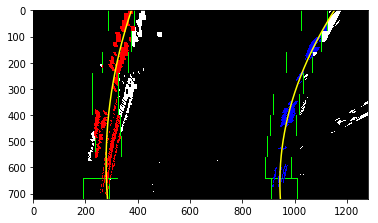

In [61]:
#Code cell 11
binary_warped = np.copy(warped)

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 50
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

#print ("Left Shape->",left_fit.shape, leftx.shape, lefty.shape)
#print ("Left-> ",left_fit, leftx, lefty)
#print ("Right-> ",right_fit, right_fitx)